# Learning prompts for transfer learning with test-time adaptation

In [42]:
import os
import time
import random
import argparse
import numpy as np
from PIL import Image
from enum import Enum
from typing import Tuple
from copy import deepcopy
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.parallel
from torch.utils.data import Dataset, DataLoader
import torch.backends.cudnn as cudnn

import torchvision.models as models
import torchvision.transforms as transforms
try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

In [43]:
import logging

# create a logger for the experiment to save logs in a file
logger = logging.getLogger('tpt_classification')
logger.setLevel(logging.DEBUG)
fh = logging.FileHandler('tpt_classification.log')
fh.setLevel(logging.DEBUG)
logger.addHandler(fh)

In [44]:
logger.info("Logger initialized at date: {}".format(time.asctime()))

## Data Supporting Variables, Classes and Functions

In [45]:
from torchvision import datasets

In [46]:
class PetsDataset(Dataset):
    def __init__(self, image_path, json_path, mode='train', transform=None):
        self.transform = transform
        self.image_path = image_path
        self.split_json = json_path
        self.mode = mode
        self.image_list = []
        self.label_list = []
        
        with open(self.split_json) as fp:
            splits = json.load(fp)
            samples = splits[self.mode]
            for s in samples:
                self.image_list.append(s[0])
                self.label_list.append(s[1])
                
    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_path, self.image_list[idx])
        image = Image.open(image_path).convert('RGB')
        label = self.label_list[idx]
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label).long()

In [47]:
def filter_food101_test_set(dataset, data_root):
    if data_root.__contains__("/images"):
        test_file_path = os.path.join(data_root.split("/images")[0], 'meta', 'test.txt')
    else:
        test_file_path = os.path.join(data_root, 'meta', 'test.txt')
        
    with open(test_file_path, 'r') as file:
        test_image_paths = set(file.read().splitlines())

    test_indices = [i for i, (path, _) in enumerate(dataset.samples) if '/'.join(path.split('/')[-2:])[:-4] in test_image_paths]
    
    return torch.utils.data.Subset(dataset, test_indices)

In [48]:
def build_dataset(set_id, transform, data_root, mode='test'):
    data_root = os.path.join(data_root, ID_to_DIRNAME[set_id.lower()])
    if set_id.lower() == 'cifar100':
        dataset = datasets.CIFAR100(root=data_root, train=(mode == 'train'), transform=transform, 
                                    download=True)
    elif set_id.lower() == 'cifar10':
        dataset = datasets.CIFAR10(root=data_root, train=(mode == 'train'), transform=transform,
                                   download=True)
        global cifar10_classes
        cifar10_classes = dataset.classes
    elif set_id.lower() == 'food101':
        dataset = datasets.ImageFolder(root=data_root, transform=transform)
        
        if mode == 'test':
            dataset = filter_food101_test_set(dataset, data_root)
            
    elif set_id.lower() == 'pets':
        path_suffix, json_path = path_dict[set_id.lower()]
        image_path = os.path.join(data_root, path_suffix)
        dataset = PetsDataset(image_path, json_path, mode, transform)
    else:
        raise NotImplementedError
        
    return dataset

## Data Augmentation

In [49]:
import data_augmentation.augmix_ops as augmentations

In [50]:
def get_pre_augmentation():
    return transforms.Compose([transforms.RandomResizedCrop(224), transforms.RandomHorizontalFlip()])

In [51]:
def augmentation_mix(image, preprocess, aug_list, severity=1):
    pre_augmentation = get_pre_augmentation()
    x_orig = pre_augmentation(image)
    x_processed = preprocess(x_orig)
    
    if len(aug_list) == 0:
        return x_processed
    
    w = np.float32(np.random.dirichlet([1.0, 1.0, 1.0]))
    m = np.float32(np.random.beta(1.0, 1.0))

    mix = torch.zeros_like(x_processed)
    
    for i in range(3):
        x_aug = x_orig.copy()
        for _ in range(np.random.randint(1, 4)):
            x_aug = np.random.choice(aug_list)(x_aug, severity)
        mix += w[i] * preprocess(x_aug)
    
    mix = m * x_processed + (1 - m) * mix
    
    return mix

In [52]:
class AugMixAugmenter(object):
    def __init__(self, base_transform, preprocess, n_views=2, is_augmentation_mix=False, severity=1):
        self.base_transform = base_transform
        self.preprocess = preprocess
        self.n_views = n_views
        if is_augmentation_mix:
            self.aug_list = augmentations.augmentations
        else:
            self.aug_list = []
            
        self.severity = severity
        
    def __call__(self, x):
        image = self.preprocess(self.base_transform(x))
        views = [
            augmentation_mix(x, self.preprocess, self.aug_list, self.severity) 
            for _ in range(self.n_views)
        ]
        
        return [image] + views

## Evaluation Metrics

In [53]:
class Summary(Enum):
    NONE = 0
    AVERAGE = 1
    SUM = 2
    COUNT = 3

In [54]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self, name, fmt=':f', summary_type=Summary.AVERAGE):
        self.val = None
        self.avg = None
        self.sum = None
        self.count = None
        
        self.name = name
        self.fmt = fmt
        self.summary_type = summary_type
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

    def __str__(self):
        fmtstr = '{name} {val' + self.fmt + '} ({avg' + self.fmt + '})'
        return fmtstr.format(**self.__dict__)
    
    def summary(self):
        if self.summary_type is Summary.NONE:
            fmtstr = ''
        elif self.summary_type is Summary.AVERAGE:
            fmtstr = '{name} {avg:.3f}'
        elif self.summary_type is Summary.SUM:
            fmtstr = '{name} {sum:.3f}'
        elif self.summary_type is Summary.COUNT:
            fmtstr = '{name} {count:.3f}'
        else:
            raise ValueError('invalid summary type %r' % self.summary_type)
        
        return fmtstr.format(**self.__dict__)

In [55]:
class ProgressMeter(object):
    def __init__(self, num_batches, meters, prefix=""):
        self.batch_fmtstr = self._get_batch_fmtstr(num_batches)
        self.meters = meters
        self.prefix = prefix

    def display(self, batch):
        entries = [self.prefix + self.batch_fmtstr.format(batch)]
        entries += [str(meter) for meter in self.meters]
        logger.info('\t'.join(entries))
        
    def display_summary(self):
        entries = [" *"]
        entries += [meter.summary() for meter in self.meters]
        logger.info(' '.join(entries))

    @staticmethod
    def _get_batch_fmtstr(num_batches):
        num_digits = len(str(num_batches // 1))
        fmt = '{:' + str(num_digits) + 'd}'
        return '[' + fmt + '/' + fmt.format(num_batches) + ']'

In [56]:
def accuracy(output, target, top_k=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        max_k = max(top_k)
        batch_size = target.size(0)

        _, pred = output.topk(max_k, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in top_k:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
            
        return res

In [57]:
def validate(val_loader, model, criterion, args, output_mask=None):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    losses = AverageMeter('Loss', ':.4e', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)
    progress = ProgressMeter(
        len(val_loader),
        [batch_time, losses, top1, top5],
        prefix='Test: ')

    # switch to evaluate mode
    model.eval()

    with torch.no_grad():
        end = time.time()
        for i, (images, target) in enumerate(val_loader):
            if args.gpu is not None:
                images = images.cuda(args.gpu, non_blocking=True)
            if torch.cuda.is_available():
                target = target.cuda(args.gpu, non_blocking=True)

            # compute output
            with torch.cuda.amp.autocast():
                output = model(images)
                if output_mask:
                    output = output[:, output_mask]
                loss = criterion(output, target)

            # measure accuracy and record loss
            acc1, acc5 = accuracy(output, target, top_k=(1, 5))
            losses.update(loss.item(), images.size(0))
            top1.update(acc1[0], images.size(0))
            top5.update(acc5[0], images.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % args.print_freq == 0:
                progress.display(i)
        progress.display_summary()

    return top1.avg

## CLIP Supporting Variables, Classes and Functions

In [58]:
from clip.clip import load, tokenize
from clip.simple_tokenizer import SimpleTokenizer as _Tokenizer

In [59]:
_tokenizer = _Tokenizer()

DOWNLOAD_ROOT = '~/.cache/clip'

In [60]:
class ClipImageEncoder(nn.Module):
    def __init__(self, device, arch="ViT-L/14", image_resolution=224, n_class=1000):
        super(ClipImageEncoder, self).__init__()
        clip, embed_dim, _ = load(arch, device=device, download_root=DOWNLOAD_ROOT)
        self.encoder = clip.visual
        del clip.transformer
        torch.cuda.empty_cache()

        self.cls_head = nn.Linear(embed_dim, n_class)

    @property
    def dtype(self):
        return self.encoder.conv1.weight.dtype

    def forward(self, image):
        x = self.encoder(image.type(self.dtype))
        output = self.cls_head(x)
        return output

In [61]:
class TextEncoder(nn.Module):
    def __init__(self, clip_model):
        super().__init__()
        self.transformer = clip_model.transformer
        self.positional_embedding = clip_model.positional_embedding
        self.ln_final = clip_model.ln_final
        self.text_projection = clip_model.text_projection
        self.dtype = clip_model.dtype

    def forward(self, prompts, tokenized_prompts):
        x = prompts + self.positional_embedding.type(self.dtype)
        x = x.permute(1, 0, 2)  # NLD -> LND
        x = self.transformer(x)
        x = x.permute(1, 0, 2)  # LND -> NLD
        x = self.ln_final(x).type(self.dtype)

        # x.shape = [batch_size, n_ctx, transformer.width]
        # take features from the eot embedding (eot_token is the highest number in each sequence)
        x = x[torch.arange(x.shape[0]), tokenized_prompts.argmax(dim=-1)] @ self.text_projection

        return x

## Test-Time Prompt Tuning/Learning (TPT) + CoOp/CoCoOp

## CoOp

In [62]:
class PromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, batch_size=None, n_ctx=16, ctx_init=None, 
                 ctx_position='end', learned_cls=False):
        super().__init__()
        n_cls = len(classnames)
        self.learned_cls = learned_cls
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = clip_model.visual.conv1.weight.device
        ctx_dim = clip_model.ln_final.weight.shape[0]
        self.ctx_dim = ctx_dim
        self.batch_size = batch_size

        # self.ctx, prompt_prefix = self.reset_prompt(ctx_dim, ctx_init, clip_model)

        if ctx_init:
            # use given words to initialize context vectors
            logger.info("Initializing the context with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            if '[CLS]' in ctx_init:
                ctx_list = ctx_init.split(" ")
                split_idx = ctx_list.index("[CLS]")
                ctx_init = ctx_init.replace("[CLS] ", "")
                ctx_position = "middle"
            else:
                split_idx = None
                
            self.split_idx = split_idx
            n_ctx = len(ctx_init.split(" "))
            prompt = tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1: 1 + n_ctx, :]
            prompt_prefix = ctx_init
        else:
            logger.info("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)

        self.prompt_prefix = prompt_prefix

        logger.info(f'Initial context: "{prompt_prefix}"')
        
        logger.info(f"Number of context words (tokens): {n_ctx}")

        # batch-wise prompt tuning for test-time adaptation
        if self.batch_size is not None:
            ctx_vectors = ctx_vectors.repeat(batch_size, 1, 1)  # (N, L, D)
        self.ctx_init_state = ctx_vectors.detach().clone()
        self.ctx = nn.Parameter(ctx_vectors)  # to be optimized

        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [prompt_prefix + " " + name + "." for name in classnames]
        else:
            logger.info("Random initialization: initializing a learnable class token")
            cls_vectors = torch.empty(n_cls, 1, ctx_dim, dtype=dtype)  # assume each learnable cls_token is only 1 word
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [prompt_prefix + " " + cls_token + "." for _ in classnames]

            self.cls_init_state = cls_vectors.detach().clone()
            self.cls = nn.Parameter(cls_vectors)  # to be optimized

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        if self.learned_cls:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx + 1:, :])  # ..., EOS
        else:
            self.register_buffer("token_suffix", embedding[:, 1 + n_ctx:, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx
        self.classnames = classnames

    def reset(self):
        ctx_vectors = self.ctx_init_state
        self.ctx.copy_(ctx_vectors)  # to be optimized
        if self.learned_cls:
            cls_vectors = self.cls_init_state
            self.cls.copy_(cls_vectors)

    def reset_classnames(self, classnames, arch):
        self.n_cls = len(classnames)
        if not self.learned_cls:
            classnames = [name.replace("_", " ") for name in classnames]
            name_lens = [len(_tokenizer.encode(name)) for name in classnames]
            prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        else:
            # assume each learnable cls_token is only 1 word
            cls_vectors = torch.empty(self.n_cls, 1, self.ctx_dim, dtype=self.dtype)
            nn.init.normal_(cls_vectors, std=0.02)
            cls_token = "X"
            name_lens = [1 for _ in classnames]
            prompts = [self.prompt_prefix + " " + cls_token + "." for _ in classnames]
            # TODO: re-init the cls parameters
            # self.cls = nn.Parameter(cls_vectors) # to be optimized
            self.cls_init_state = cls_vectors.detach().clone()
        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)

        clip, _, _ = load(arch, device=self.device, download_root=DOWNLOAD_ROOT)

        with torch.no_grad():
            embedding = clip.token_embedding(tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx:, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts
        self.classnames = classnames

    def forward(self, init=None):
        # the init will be used when computing CLIP directional loss
        if init is not None:
            ctx = init
        else:
            ctx = self.ctx
        if ctx.dim() == 2:
            ctx = ctx.unsqueeze(0).expand(self.n_cls, -1, -1)
        elif not ctx.size()[0] == self.n_cls:
            ctx = ctx.unsqueeze(1).expand(-1, self.n_cls, -1, -1)

        prefix = self.token_prefix
        suffix = self.token_suffix
        if self.batch_size is not None:
            # This way only works for single-gpu setting (could pass batch size as an argument for forward())
            prefix = prefix.repeat(self.batch_size, 1, 1, 1)
            suffix = suffix.repeat(self.batch_size, 1, 1, 1)

        if self.learned_cls:
            assert self.class_token_position == "end"
        if self.class_token_position == "end":
            if self.learned_cls:
                cls = self.cls
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,  # (n_cls, n_ctx, dim)
                        cls,  # (n_cls, 1, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
            else:
                prompts = torch.cat(
                    [
                        prefix,  # (n_cls, 1, dim)
                        ctx,  # (n_cls, n_ctx, dim)
                        suffix,  # (n_cls, *, dim)
                    ],
                    dim=-2,
                )
        elif self.class_token_position == "middle":
            # TODO: to work with a batch of prompts
            if self.split_idx is not None:
                half_n_ctx = self.split_idx  # split the ctx at the position of [CLS] in `ctx_init`
            else:
                half_n_ctx = self.n_ctx // 2
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i_half1 = ctx[i: i + 1, :half_n_ctx, :]
                ctx_i_half2 = ctx[i: i + 1, half_n_ctx:, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        ctx_i_half1,  # (1, n_ctx//2, dim)
                        class_i,  # (1, name_len, dim)
                        ctx_i_half2,  # (1, n_ctx//2, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        elif self.class_token_position == "front":
            prompts = []
            for i in range(self.n_cls):
                name_len = self.name_lens[i]
                prefix_i = prefix[i: i + 1, :, :]
                class_i = suffix[i: i + 1, :name_len, :]
                suffix_i = suffix[i: i + 1, name_len:, :]
                ctx_i = ctx[i: i + 1, :, :]
                prompt = torch.cat(
                    [
                        prefix_i,  # (1, 1, dim)
                        class_i,  # (1, name_len, dim)
                        ctx_i,  # (1, n_ctx, dim)
                        suffix_i,  # (1, *, dim)
                    ],
                    dim=1,
                )
                prompts.append(prompt)
            prompts = torch.cat(prompts, dim=0)

        else:
            raise ValueError

        return prompts

In [63]:
class ClipTestTimeTuning(nn.Module):
    def __init__(self, device, classnames, batch_size, criterion='cosine', arch="ViT-L/14",
                 n_ctx=16, ctx_init=None, ctx_position='end', learned_cls=False):
        super(ClipTestTimeTuning, self).__init__()
        clip, _, _ = load(arch, device=device, download_root=DOWNLOAD_ROOT)
        self.image_encoder = clip.visual
        self.text_encoder = TextEncoder(clip)
        self.logit_scale = clip.logit_scale.data
        
        # prompt tuning
        self.prompt_learner = PromptLearner(
            clip, classnames, batch_size, n_ctx, ctx_init, ctx_position, learned_cls
        )
        
        self.criterion = criterion

    @property
    def dtype(self):
        return self.image_encoder.conv1.weight.dtype

    # restore the initial state of the prompt_learner (tunable prompt)
    def reset(self):
        self.prompt_learner.reset()

    def reset_classnames(self, classnames, arch):
        self.prompt_learner.reset_classnames(classnames, arch)

    def get_text_features(self):
        text_features = []
        prompts = self.prompt_learner()
        tokenized_prompts = self.prompt_learner.tokenized_prompts
        t_features = self.text_encoder(prompts, tokenized_prompts)
        text_features.append(t_features / t_features.norm(dim=-1, keepdim=True))
        text_features = torch.stack(text_features, dim=0)

        return torch.mean(text_features, dim=0)

    def inference(self, image):
        with torch.no_grad():
            image_features = self.image_encoder(image.type(self.dtype))

        text_features = self.get_text_features()
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        logit_scale = self.logit_scale.exp()
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def forward(self, input_):
        if isinstance(input_, Tuple):
            view_0, view_1, view_2 = input_
            return self.contrast_prompt_tuning(view_0, view_1, view_2)
        elif len(input_.size()) == 2:
            return self.directional_prompt_tuning(input_)
        else:
            return self.inference(input_)

In [64]:
def load_model_weight(load_path, model, device, args):
    if os.path.isfile(load_path):
        logger.info("=> loading checkpoint '{}'".format(load_path))
        checkpoint = torch.load(load_path, map_location=device)
        state_dict = checkpoint['state_dict']
        # Ignore fixed token vectors
        if "token_prefix" in state_dict:
            del state_dict["token_prefix"]

        if "token_suffix" in state_dict:
            del state_dict["token_suffix"]

        args.start_epoch = checkpoint['epoch']
        
        try:
            best_acc1 = checkpoint['best_acc1']
        except:
            best_acc1 = torch.tensor(0)
            
        if device != 'cpu':
            # best_acc1 may be from a checkpoint from a different GPU
            best_acc1 = best_acc1.to(device)
        
        try:
            model.load_state_dict(state_dict)
        except:
            # TODO: implement this method for the generator class
            model.prompt_generator.load_state_dict(state_dict, strict=False)
        
        logger.info("=> loaded checkpoint '{}' (epoch {})".format(load_path, checkpoint['epoch']))
        
        del checkpoint
        torch.cuda.empty_cache()
    
    else:
        logger.error("=> no checkpoint found at '{}'".format(load_path))

In [65]:
def get_coop(clip_arch, test_set, device, n_ctx, ctx_init, learned_cls=False):
    classnames = eval("{}_classes".format(test_set.lower()))

    model = ClipTestTimeTuning(device, classnames, None, arch=clip_arch, n_ctx=n_ctx, ctx_init=ctx_init, learned_cls=learned_cls)

    return model

## CoCoOp

In [66]:
class CoCoOpPromptLearner(nn.Module):
    def __init__(self, clip_model, classnames, n_ctx=4, ctx_init="a_photo_of_a", ctx_position='end'):
        super().__init__()
        
        n_cls = len(classnames)
        dtype = clip_model.dtype
        self.dtype = dtype
        self.device = clip_model.visual.conv1.weight.device
        ctx_dim = clip_model.ln_final.weight.shape[0]
        embed_dim = clip_model.text_projection.shape[1]
        self.ctx_dim = ctx_dim

        if ctx_init:
            # use given words to initialize context vectors
            logger.info("Initializing the context with given words: [{}]".format(ctx_init))
            ctx_init = ctx_init.replace("_", " ")
            n_ctx = len(ctx_init.split(" "))
            prompt = tokenize(ctx_init).to(self.device)
            with torch.no_grad():
                embedding = clip_model.token_embedding(prompt).type(dtype)
            ctx_vectors = embedding[0, 1 : 1 + n_ctx, :]
            prompt_prefix = ctx_init

        else:
            logger.info("Random initialization: initializing a generic context")
            ctx_vectors = torch.empty(n_ctx, ctx_dim, dtype=dtype)
            nn.init.normal_(ctx_vectors, std=0.02)
            prompt_prefix = " ".join(["X"] * n_ctx)
            
        logger.info(f'Initial context: "{prompt_prefix}"')
        logger.info(f"Number of context words (tokens): {n_ctx}")
        self.prompt_prefix = prompt_prefix

        self.ctx = nn.Parameter(ctx_vectors) # to be optimized
        self.meta_net = nn.Sequential(OrderedDict([
            ("linear1", nn.Linear(embed_dim, embed_dim // 16)),
            ("relu", nn.ReLU(inplace=True)),
            ("linear2", nn.Linear(embed_dim // 16, ctx_dim))
        ]))

        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [prompt_prefix + " " + name + "." for name in classnames]

        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)
        with torch.no_grad():
            embedding = clip_model.token_embedding(tokenized_prompts).type(dtype)

        # These token vectors will be saved when in save_model(),
        # but they should be ignored in load_model() as we want to use
        # those computed using the current class names
        self.register_buffer("token_prefix", embedding[:, :1, :])  # SOS
        self.register_buffer("token_suffix", embedding[:, 1 + n_ctx :, :])  # CLS, EOS

        self.ctx_init = ctx_init
        self.tokenized_prompts = tokenized_prompts  # torch.Tensor
        self.name_lens = name_lens
        self.class_token_position = ctx_position
        self.n_cls = n_cls
        self.n_ctx = n_ctx

    @staticmethod
    def construct_prompts(ctx, prefix, suffix, label=None):
        # dim0 is either batch_size (during training) or n_cls (during testing)
        # ctx: context tokens, with shape of (dim0, n_ctx, ctx_dim)
        # prefix: the sos token, with shape of (n_cls, 1, ctx_dim)
        # suffix: remaining tokens, with shape of (n_cls, *, ctx_dim)

        if label is not None:
            prefix = prefix[label]
            suffix = suffix[label]

        prompts = torch.cat(
            [
                prefix,  # (dim0, 1, dim)
                ctx,     # (dim0, n_ctx, dim)
                suffix,  # (dim0, *, dim)
            ],
            dim=1,
        )

        return prompts

    def reset_classnames(self, classnames, arch):
        self.n_cls = len(classnames)
        classnames = [name.replace("_", " ") for name in classnames]
        name_lens = [len(_tokenizer.encode(name)) for name in classnames]
        prompts = [self.prompt_prefix + " " + name + "." for name in classnames]
        tokenized_prompts = torch.cat([tokenize(p) for p in prompts]).to(self.device)

        clip, _, _ = load(arch, device=self.device, download_root=DOWNLOAD_ROOT)

        with torch.no_grad():
            embedding = clip.token_embedding(tokenized_prompts).type(self.dtype)

        self.token_prefix = embedding[:, :1, :]
        self.token_suffix = embedding[:, 1 + self.n_ctx :, :]  # CLS, EOS

        self.name_lens = name_lens
        self.tokenized_prompts = tokenized_prompts

    def forward(self, im_features, ctx_only=False):
        prefix = self.token_prefix
        suffix = self.token_suffix
        ctx = self.ctx                     # (n_ctx, ctx_dim)
        bias = self.meta_net(im_features)  # (batch, ctx_dim)
        bias = bias.unsqueeze(1)           # (batch, 1, ctx_dim)
        ctx = ctx.unsqueeze(0)             # (1, n_ctx, ctx_dim)
        ctx_shifted = ctx + bias           # (batch, n_ctx, ctx_dim)
        if ctx_only:
            return ctx_shifted # don't expand to n_cls, optimize one ctx for all classes
        
        # Use instance-conditioned context tokens for all classes
        prompts = []
        for ctx_shifted_i in ctx_shifted:
            ctx_i = ctx_shifted_i.unsqueeze(0).expand(self.n_cls, -1, -1)
            pts_i = self.construct_prompts(ctx_i, prefix, suffix)  # (n_cls, n_tkn, ctx_dim)
            prompts.append(pts_i)
        prompts = torch.stack(prompts)
        
        return prompts

In [67]:
class CoCoOpCLIP(nn.Module):
    def __init__(self, device, classnames, criterion='cosine', arch="ViT-L/14", n_ctx=16, ctx_init="a_photo_of_a", ctx_position='end'):
        super().__init__()
        
        clip, _, _ = load(arch, device=device, download_root=DOWNLOAD_ROOT)
        self.image_encoder = clip.visual
        self.text_encoder = TextEncoder(clip)
        self.logit_scale = clip.logit_scale.data
        # prompt tuning
        self.prompt_generator = CoCoOpPromptLearner(clip, classnames, n_ctx, ctx_init, ctx_position)
        self.tokenized_prompts = self.prompt_generator.tokenized_prompts
        self.criterion = criterion
        self.dtype = clip.dtype

    def inference(self, image, label=None):
        tokenized_prompts = self.prompt_generator.tokenized_prompts
        logit_scale = self.logit_scale.exp()

        image_features = self.image_encoder(image.type(self.dtype))
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)

        prompts = self.prompt_generator(image_features)
    
        logits_ = []
        for pts_i, imf_i in zip(prompts, image_features):
            text_features = self.text_encoder(pts_i, tokenized_prompts)
            text_features = text_features / text_features.norm(dim=-1, keepdim=True)
            l_i = logit_scale * imf_i @ text_features.t()
            logits_.append(l_i)
            
        logits_ = torch.stack(logits_)

        return logits_

    def gen_ctx(self, image, aug=False):
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                image_features = self.image_encoder(image.type(self.dtype))
                if aug:
                    image_feature_avg = image_features[0].unsqueeze(0)
                else:
                    image_feature_avg = image_features.mean(dim=0, keepdim=True)
                ctx = self.prompt_generator(image_feature_avg, ctx_only=True)

        return image_features, ctx.detach().clone()

    def forward_ctx(self, image_features, ctx):
        N = 1
        
        prefix = self.prompt_generator.token_prefix.expand(N, -1, -1, -1) # [N, n_cls, 1, dim]
        suffix = self.prompt_generator.token_suffix.expand(N, -1, -1, -1)
        # expand `ctx` n_cls times
        ctx = ctx.expand(self.prompt_generator.n_cls, -1, -1, -1)
        ctx = ctx.permute(1, 0, 2, 3)
        
        # ctx = ctx.reshape(N, self.prompt_generator.n_cls, -1, self.prompt_generator.ctx_dim)

        prompts = torch.cat([
            prefix,
            ctx,
            suffix
        ], dim=-2)

        # full_n_ctx = prompts.size()[-2]

        prompts = prompts.reshape(N * self.prompt_generator.n_cls, -1, self.prompt_generator.ctx_dim)
        tokenized_prompts = self.prompt_generator.tokenized_prompts
        tokenized_prompts = tokenized_prompts.repeat(N, 1)
        text_features = self.text_encoder(prompts, tokenized_prompts)

        text_features = text_features / text_features.norm(dim=-1, keepdim=True)
        image_features = image_features / image_features.norm(dim=-1, keepdim=True)
        
        text_features = text_features.reshape(N, -1, image_features.size()[-1])

        logit_scale = self.logit_scale.exp()

        text_features = text_features.squeeze(0)
        logits = logit_scale * image_features @ text_features.t()

        return logits

    def forward(self, input_):
        if isinstance(input_, Tuple):
            image_features, ctx = input_
            return self.forward_ctx(image_features, ctx)
        else:
            return self.inference(input_)

In [68]:
def get_cocoop(clip_arch, test_set, device, n_ctx):
    classnames = eval("{}_classes".format(test_set.lower()))
    model = CoCoOpCLIP(device, classnames, arch=clip_arch, n_ctx=n_ctx)

    return model

## TPT Classification

In [69]:
model_names = sorted(name for name in models.__dict__ if name.islower() and not name.startswith("__") and callable(models.__dict__[name]))

In [70]:
def select_confident_samples(logits, top):
    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * top)]
    return logits[idx], idx

In [71]:
def avg_entropy(outputs):
    logits = outputs - outputs.logsumexp(dim=-1, keepdim=True) # logits = outputs.log_softmax(dim=1) [N, 1000]
    avg_logits = logits.logsumexp(dim=0) - np.log(logits.shape[0]) # avg_logits = logits.mean(0) [1, 1000]
    min_real = torch.finfo(avg_logits.dtype).min
    avg_logits = torch.clamp(avg_logits, min=min_real)
    return -(avg_logits * torch.exp(avg_logits)).sum(dim=-1)

In [72]:
def test_time_tuning(model, inputs, optimizer, scaler, args):
    image_feature = None
    pgen_ctx = None
    
    if args.cocoop:
        image_feature, pgen_ctx = inputs
        pgen_ctx.requires_grad = True
        optimizer = torch.optim.AdamW([pgen_ctx], args.lr)
    
    selected_idx = None
    for j in range(args.tta_steps):
        with torch.cuda.amp.autocast():
            if args.cocoop:
                output = model((image_feature, pgen_ctx))
            else:
                output = model(inputs) 

            if selected_idx is not None:
                output = output[selected_idx]
            else:
                output, selected_idx = select_confident_samples(output, args.selection_p)

            loss = avg_entropy(output)
        
        optimizer.zero_grad()
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        # Unscales the gradients of optimizers assigned params in-place
        scaler.step(optimizer)
        scaler.update()
        
    if args.cocoop:
        return pgen_ctx

    return

In [73]:
def test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler, args):
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)

    progress = ProgressMeter(len(val_loader), [batch_time, top1, top5], prefix='Test: ')

    # reset model and switch to evaluate mode
    model.eval()
    if not args.cocoop: # no need to reset cocoop because it's fixed
        with torch.no_grad():
            model.reset()
            
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
        assert args.gpu is not None
        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(args.gpu, non_blocking=True)
            image = images[0]
        else:
            images = images.cuda(args.gpu, non_blocking=True)
            image = images
        target = target.cuda(args.gpu, non_blocking=True)
        if args.tpt:
            images = torch.cat(images, dim=0)
        
        image_feature = None
        pgen_ctx = None
        
        # reset the tunable prompt to its initial state
        if not args.cocoop: # no need to reset cocoop because it's fixed
            if args.tta_steps > 0:
                with torch.no_grad():
                    model.reset()
            optimizer.load_state_dict(optim_state)
            test_time_tuning(model, images, optimizer, scaler, args)
        else:
            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    image_feature, pgen_ctx = model.gen_ctx(images, args.tpt)
            optimizer = None
            pgen_ctx = test_time_tuning(model, (image_feature, pgen_ctx), optimizer, scaler, args)

        # The actual inference goes here
        if args.tpt:
            if args.cocoop:
                image_feature = image_feature[0].unsqueeze(0)
        
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                if args.cocoop:
                    output = model((image_feature, pgen_ctx))
                else:
                    output = model(image)
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, top_k=(1, 5))
                
        top1.update(acc1[0], image.size(0))
        top5.update(acc5[0], image.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args.print_freq == 0:
            progress.display(i)

    progress.display_summary()

    return [top1.avg, top5.avg]

In [78]:
def tpt_classification(args):
    random.seed(args.seed)
    np.random.seed(args.seed)
    torch.manual_seed(args.seed)
    torch.cuda.manual_seed_all(args.seed)
    logger.info("Use GPU: {} for training".format(args.gpu))

    if args.cocoop:
        model = get_cocoop(args.arch, args.test_sets, 'cpu', args.n_ctx)
        
        assert args.pretrained_model is not None
        
        # to load to cuda: device="cuda:{}".format(args.gpu)
        load_model_weight(args.pretrained_model, model, 'cpu', args) 
        model_state = deepcopy(model.state_dict())
    else:
        model = get_coop(args.arch, args.test_sets, args.gpu, args.n_ctx, args.ctx_init)
        
        if args.pretrained_model is not None:
            logger.info("Use pre-trained soft prompt (CoOp) as initialization")
            pretrained_ctx = torch.load(args.pretrained_model)['state_dict']['ctx']
            assert pretrained_ctx.size()[0] == args.n_ctx
            with torch.no_grad():
                model.prompt_learner.ctx.copy_(pretrained_ctx)
                model.prompt_learner.ctx_init_state = pretrained_ctx
                
        model_state = None

    for name, param in model.named_parameters():
        if not args.cocoop:
            if "prompt_learner" not in name:
                param.requires_grad_(False)
        else:
            if "text_encoder" not in name:
                param.requires_grad_(False)
    
    logger.info("=> Model created: visual backbone {}".format(args.arch))
    
    if not torch.cuda.is_available():
        logger.info('using CPU, this will be slow')
    else:
        assert args.gpu is not None
        torch.cuda.set_device(args.gpu)
        model = model.cuda(args.gpu)

    # define optimizer
    if args.cocoop:
        optimizer = None
        optim_state = None
    else:
        trainable_param = model.prompt_learner.parameters()
        optimizer = torch.optim.AdamW(trainable_param, args.lr)
        optim_state = deepcopy(optimizer.state_dict())

    # setup automatic mixed-precision (Amp) loss scaling
    scaler = torch.cuda.amp.GradScaler(init_scale=1000)

    logger.info('=> Using native Torch AMP. Training in mixed precision.')

    cudnn.benchmark = True

    # norm stats from clip.load()
    normalize = transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073],
        std=[0.26862954, 0.26130258, 0.27577711]
    )

    # iterating through eval datasets
    datasets_ = args.test_sets.split("/")
    results = {}
    for set_id in datasets_:
        if args.tpt:
            base_transform = transforms.Compose([
                transforms.Resize(args.resolution, interpolation=BICUBIC),
                transforms.CenterCrop(args.resolution)]
            )
            preprocess = transforms.Compose([transforms.ToTensor(), normalize])
            data_transform = AugMixAugmenter(
                base_transform, preprocess, n_views=args.augmented_views - 1, 
                is_augmentation_mix=len(set_id) > 1
            )
            batch_size_ = 1
        else:
            data_transform = transforms.Compose([
                transforms.Resize(args.resolution, interpolation=BICUBIC),
                transforms.CenterCrop(args.resolution),
                transforms.ToTensor(),
                normalize,
            ])
            batch_size_ = args.batch_size

        logger.info("evaluating: {}".format(set_id))
        # reset the model
        # Reset classnames of custom CLIP model
        classnames = eval("{}_classes".format(set_id.lower()))
        
        if args.cocoop:
            model.prompt_generator.reset_classnames(classnames, args.arch)
            model = model.cpu()
            model_state = model.state_dict()
            model = model.cuda(args.gpu)
        else:
            model.reset_classnames(classnames, args.arch)
            
        val_dataset = build_dataset(set_id, data_transform, args.data, mode=args.dataset_mode)
        logger.info("number of test samples: {}".format(len(val_dataset)))
        val_loader = torch.utils.data.DataLoader(
            val_dataset,
            batch_size=batch_size_, shuffle=True,
            num_workers=args.workers, pin_memory=True
        )
            
        results[set_id] = test_time_adapt_eval(val_loader, model, optimizer, optim_state, scaler, args)
        del val_dataset, val_loader
        try:
            logger.info("=> Acc. on test_set [{}]: @1 {}/ @5 {}".format(set_id, results[set_id][0], results[set_id][1]))
        except:
            logger.info("=> Acc. on test_set [{}]: {}".format(set_id, results[set_id]))

    logger.info("======== Result Summary ========")
    logger.info("params: n_step	lr	bs")
    logger.info("params: {}	{}	{}".format(args.tta_steps, args.lr, args.batch_size))
    logger.info("\t\t [set_id] \t\t Top-1 acc. \t\t Top-5 acc.")
    
    for id_ in results.keys():
        logger.info("{}".format(id_))
    
    logger.info("\n")
    
    for id_ in results.keys():
        logger.info("{:.2f}".format(results[id_][0]))
        
    logger.info("\n")

In [79]:
few_shot_datasets = ['Pets', 'Food101', 'CIFAR100', 'CIFAR10', 'MNIST']

path_dict = {
    "pets": ["", "dataset_jsons/split_zhou_OxfordPets.json"],
    "food101": ["", "dataset_jsons/split_zhou_Food101.json"],
}

ID_to_DIRNAME = {
    'pets': 'oxford_pets/images',
    'food101': 'food-101/images',
    'cifar100': 'cifar-100-python',
    'cifar10': 'cifar-10-batches-py',
    'mnist': 'MNIST'
}

In [80]:
import json

food101_classes = ['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_soup', 'mussels', 'nachos', 'omelette', 'onion_rings', 'oysters', 'pad_thai', 'paella', 'pancakes', 'panna_cotta', 'peking_duck', 'pho', 'pizza', 'pork_chop', 'poutine', 'prime_rib', 'pulled_pork_sandwich', 'ramen', 'ravioli', 'red_velvet_cake', 'risotto', 'samosa', 'sashimi', 'scallops', 'seaweed_salad', 'shrimp_and_grits', 'spaghetti_bolognese', 'spaghetti_carbonara', 'spring_rolls', 'steak', 'strawberry_shortcake', 'sushi', 'tacos', 'takoyaki', 'tiramisu', 'tuna_tartare', 'waffles']

pets_classes = ['abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'bengal', 'birman', 'bombay', 'boxer', 'british_shorthair', 'chihuahua', 'egyptian_mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'maine_coon', 'miniature_pinscher', 'newfoundland', 'persian', 'pomeranian', 'pug', 'ragdoll', 'russian_blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'siamese', 'sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']

cifar100_classes = ['apple', 'aquarium_fish', 'baby', 'bear', 'beaver', 'bed', 'bee', 'beetle', 'bicycle', 'bottle', 'bowl', 'boy', 'bridge', 'bus', 'butterfly', 'camel', 'can', 'castle', 'caterpillar', 'cattle', 'chair', 'chimpanzee', 'clock', 'cloud', 'cockroach', 'couch', 'crab', 'crocodile', 'cup', 'dinosaur', 'dolphin', 'elephant', 'flatfish', 'forest', 'fox', 'girl', 'hamster', 'house', 'kangaroo', 'keyboard', 'lamp', 'lawn_mower', 'leopard', 'lion', 'lizard', 'lobster', 'man', 'maple_tree', 'motorcycle', 'mountain', 'mouse', 'mushroom', 'oak_tree', 'orange', 'orchid', 'otter', 'palm_tree', 'pear', 'pickup_truck', 'pine_tree', 'plain', 'plate', 'poppy', 'porcupine', 'possum', 'rabbit', 'raccoon', 'ray', 'road', 'rocket', 'rose', 'sea', 'seal', 'shark', 'shrew', 'skunk', 'skyscraper', 'snail', 'snake', 'spider', 'squirrel', 'streetcar', 'sunflower', 'sweet_pepper', 'table', 'tank', 'telephone', 'television', 'tiger', 'tractor', 'train', 'trout', 'tulip', 'turtle', 'wardrobe', 'whale', 'willow_tree', 'wolf', 'woman', 'worm']

cifar10_classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

## TPT Classification on Oxford Pets

In [81]:
%cd /root/

HOME = os.getcwd()

print(HOME)

parser = argparse.ArgumentParser(description='Test-time Prompt Tuning')
parser.add_argument('--data', metavar='DIR', default='DATA/', help='path to dataset root')
parser.add_argument('--test_sets', type=str, default='Pets', help='test dataset (multiple datasets split by slash)')
parser.add_argument('--dataset_mode', type=str, default='test', help='which split to use: train/val/test')
parser.add_argument('-a', '--arch', metavar='ARCH', default='RN50')
parser.add_argument('--resolution', default=224, type=int, help='CLIP image resolution')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=64, type=int, metavar='N')
parser.add_argument('--lr', '--learning-rate', default=5e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('-p', '--print-freq', default=200, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
parser.add_argument('--tpt', action='store_true', default=True, help='run test-time prompt tuning')
parser.add_argument('--augmented_views', default=64, type=int, help='number of augmented views (normally equals to batch size)')
parser.add_argument('--selection_p', default=0.1, type=float, help='confidence selection percentile')
parser.add_argument('--tta_steps', default=1, type=int, help='test-time-adapt steps')
parser.add_argument('--n_ctx', default=4, type=int, help='number of tunable tokens')
parser.add_argument('--ctx_init', default=None, type=str, help='init tunable prompts')
parser.add_argument('--cocoop', action='store_true', default=False, help="use cocoop output as prompt initialization")
parser.add_argument('--pretrained_model', default="pretrained/to_gdrive/rn50_ep50_16shots/nctx4_cscFalse_ctpend/seed1/prompt_learner/model.pth", type=str, help='path to a pre-trained coop/cocoop')
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('-f')

args_ = parser.parse_args()

tpt_classification(args_)

/root
/root


INFO:root:Using NamedTuple = typing._NamedTuple instead.


[2023-12-20 01:17:04.394 pytorch-1-13-gpu-p-ml-g4dn-2xlarge-6961a72e1df1f74b220c1ad7ffa1:21 INFO utils.py:28] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2023-12-20 01:17:04.724 pytorch-1-13-gpu-p-ml-g4dn-2xlarge-6961a72e1df1f74b220c1ad7ffa1:21 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.


INFO:tpt_classification:Test: [ 199/3669]	Time  0.220 ( 0.261)	Acc@1 100.00 ( 92.50)	Acc@5 100.00 ( 99.50)
INFO:tpt_classification:Test: [ 399/3669]	Time  0.201 ( 0.246)	Acc@1 100.00 ( 88.75)	Acc@5 100.00 ( 99.00)
INFO:tpt_classification:Test: [ 599/3669]	Time  0.219 ( 0.242)	Acc@1 100.00 ( 88.00)	Acc@5 100.00 ( 99.33)
INFO:tpt_classification:Test: [ 799/3669]	Time  0.207 ( 0.240)	Acc@1 100.00 ( 88.00)	Acc@5 100.00 ( 99.12)
INFO:tpt_classification:Test: [ 999/3669]	Time  0.206 ( 0.239)	Acc@1 100.00 ( 88.30)	Acc@5 100.00 ( 98.80)
INFO:tpt_classification:Test: [1199/3669]	Time  0.216 ( 0.238)	Acc@1 100.00 ( 88.50)	Acc@5 100.00 ( 98.92)


KeyboardInterrupt: 

## TPT Classification on Food101

In [44]:
%cd /root/

HOME = os.getcwd()

print(HOME)

parser = argparse.ArgumentParser(description='Test-time Prompt Tuning')
parser.add_argument('--data', metavar='DIR', default='DATA/', help='path to dataset root')
parser.add_argument('--test_sets', type=str, default='Food101', help='test dataset (multiple datasets split by slash)')
parser.add_argument('--dataset_mode', type=str, default='test', help='which split to use: train/val/test')
parser.add_argument('-a', '--arch', metavar='ARCH', default='RN50')
parser.add_argument('--resolution', default=224, type=int, help='CLIP image resolution')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=64, type=int, metavar='N')
parser.add_argument('--lr', '--learning-rate', default=5e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('-p', '--print-freq', default=200, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
parser.add_argument('--tpt', action='store_true', default=True, help='run test-time prompt tuning')
parser.add_argument('--augmented_views', default=64, type=int, help='number of augmented views (normally equals to batch size)')
parser.add_argument('--selection_p', default=0.1, type=float, help='confidence selection percentile')
parser.add_argument('--tta_steps', default=1, type=int, help='test-time-adapt steps')
parser.add_argument('--n_ctx', default=4, type=int, help='number of tunable tokens')
parser.add_argument('--ctx_init', default=None, type=str, help='init tunable prompts')
parser.add_argument('--cocoop', action='store_true', default=False, help="use cocoop output as prompt initialization")
parser.add_argument('--pretrained_model', 
                    default="pretrained/to_gdrive/rn50_ep50_16shots/nctx4_cscFalse_ctpend/seed1/prompt_learner/model.pth", 
                    type=str, help='path to a pre-trained coop/cocoop')

parser.add_argument('--seed', type=int, default=0)
parser.add_argument('-f')

args_ = parser.parse_args()

tpt_classification(args_)

INFO:tpt_classification:Use GPU: 0 for training


/root
/root
Use GPU: 0 for training


INFO:tpt_classification:Random initialization: initializing a generic context
INFO:tpt_classification:Initial context: "X X X X"
INFO:tpt_classification:Number of context words (tokens): 4
INFO:tpt_classification:Use pre-trained soft prompt (CoOp) as initialization
INFO:tpt_classification:=> Model created: visual backbone RN50
INFO:tpt_classification:=> Using native Torch AMP. Training in mixed precision.
INFO:tpt_classification:evaluating: Food101


Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
evaluating: Food101


INFO:tpt_classification:number of test samples: 25250


number of test samples: 25250


INFO:tpt_classification:Test: [  199/25250]	Time  0.352 ( 0.357)	Acc@1 100.00 ( 79.00)	Acc@5 100.00 ( 93.50)


Test: [  199/25250]	Time  0.352 ( 0.357)	Acc@1 100.00 ( 79.00)	Acc@5 100.00 ( 93.50)


INFO:tpt_classification:Test: [  399/25250]	Time  0.350 ( 0.354)	Acc@1   0.00 ( 79.50)	Acc@5 100.00 ( 94.50)


Test: [  399/25250]	Time  0.350 ( 0.354)	Acc@1   0.00 ( 79.50)	Acc@5 100.00 ( 94.50)


INFO:tpt_classification:Test: [  599/25250]	Time  0.353 ( 0.354)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 94.83)


Test: [  599/25250]	Time  0.353 ( 0.354)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 94.83)


INFO:tpt_classification:Test: [  799/25250]	Time  0.351 ( 0.353)	Acc@1 100.00 ( 78.38)	Acc@5 100.00 ( 94.75)


Test: [  799/25250]	Time  0.351 ( 0.353)	Acc@1 100.00 ( 78.38)	Acc@5 100.00 ( 94.75)


INFO:tpt_classification:Test: [  999/25250]	Time  0.350 ( 0.353)	Acc@1   0.00 ( 77.50)	Acc@5 100.00 ( 94.30)


Test: [  999/25250]	Time  0.350 ( 0.353)	Acc@1   0.00 ( 77.50)	Acc@5 100.00 ( 94.30)


INFO:tpt_classification:Test: [ 1199/25250]	Time  0.352 ( 0.353)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 94.50)


Test: [ 1199/25250]	Time  0.352 ( 0.353)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 94.50)


INFO:tpt_classification:Test: [ 1399/25250]	Time  0.352 ( 0.353)	Acc@1 100.00 ( 78.71)	Acc@5 100.00 ( 94.93)


Test: [ 1399/25250]	Time  0.352 ( 0.353)	Acc@1 100.00 ( 78.71)	Acc@5 100.00 ( 94.93)


INFO:tpt_classification:Test: [ 1599/25250]	Time  0.350 ( 0.353)	Acc@1 100.00 ( 78.44)	Acc@5 100.00 ( 94.94)


Test: [ 1599/25250]	Time  0.350 ( 0.353)	Acc@1 100.00 ( 78.44)	Acc@5 100.00 ( 94.94)


INFO:tpt_classification:Test: [ 1799/25250]	Time  0.353 ( 0.353)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 95.06)


Test: [ 1799/25250]	Time  0.353 ( 0.353)	Acc@1 100.00 ( 78.67)	Acc@5 100.00 ( 95.06)


INFO:tpt_classification:Test: [ 1999/25250]	Time  0.351 ( 0.353)	Acc@1 100.00 ( 78.70)	Acc@5 100.00 ( 95.00)


Test: [ 1999/25250]	Time  0.351 ( 0.353)	Acc@1 100.00 ( 78.70)	Acc@5 100.00 ( 95.00)


INFO:tpt_classification:Test: [ 2199/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 78.91)	Acc@5 100.00 ( 95.05)


Test: [ 2199/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 78.91)	Acc@5 100.00 ( 95.05)


INFO:tpt_classification:Test: [ 2399/25250]	Time  0.353 ( 0.352)	Acc@1   0.00 ( 79.25)	Acc@5 100.00 ( 95.25)


Test: [ 2399/25250]	Time  0.353 ( 0.352)	Acc@1   0.00 ( 79.25)	Acc@5 100.00 ( 95.25)


INFO:tpt_classification:Test: [ 2599/25250]	Time  0.353 ( 0.352)	Acc@1   0.00 ( 79.38)	Acc@5 100.00 ( 95.04)


Test: [ 2599/25250]	Time  0.353 ( 0.352)	Acc@1   0.00 ( 79.38)	Acc@5 100.00 ( 95.04)


INFO:tpt_classification:Test: [ 2799/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.64)	Acc@5 100.00 ( 95.00)


Test: [ 2799/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.64)	Acc@5 100.00 ( 95.00)


INFO:tpt_classification:Test: [ 2999/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.17)	Acc@5 100.00 ( 94.83)


Test: [ 2999/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.17)	Acc@5 100.00 ( 94.83)


INFO:tpt_classification:Test: [ 3199/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.00)	Acc@5 100.00 ( 94.72)


Test: [ 3199/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 79.00)	Acc@5 100.00 ( 94.72)


INFO:tpt_classification:Test: [ 3399/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 78.94)	Acc@5 100.00 ( 94.65)


Test: [ 3399/25250]	Time  0.352 ( 0.352)	Acc@1 100.00 ( 78.94)	Acc@5 100.00 ( 94.65)


KeyboardInterrupt: 

## TPT Classification on CIFAR-10

In [46]:
%cd /root/

HOME = os.getcwd()

print(HOME)

parser = argparse.ArgumentParser(description='Test-time Prompt Tuning')
parser.add_argument('--data', metavar='DIR', default='DATA/', help='path to dataset root')
parser.add_argument('--test_sets', type=str, default='CIFAR10', help='test dataset (multiple datasets split by slash)')
parser.add_argument('--dataset_mode', type=str, default='test', help='which split to use: train/val/test')
parser.add_argument('-a', '--arch', metavar='ARCH', default='RN50')
parser.add_argument('--resolution', default=224, type=int, help='CLIP image resolution')
parser.add_argument('-j', '--workers', default=4, type=int, metavar='N', help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=64, type=int, metavar='N')
parser.add_argument('--lr', '--learning-rate', default=5e-3, type=float, metavar='LR', help='initial learning rate', dest='lr')
parser.add_argument('-p', '--print-freq', default=200, type=int, metavar='N', help='print frequency (default: 10)')
parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
parser.add_argument('--tpt', action='store_true', default=True, help='run test-time prompt tuning')
parser.add_argument('--augmented_views', default=64, type=int, help='number of augmented views (normally equals to batch size)')
parser.add_argument('--selection_p', default=0.1, type=float, help='confidence selection percentile')
parser.add_argument('--tta_steps', default=1, type=int, help='test-time-adapt steps')
parser.add_argument('--n_ctx', default=4, type=int, help='number of tunable tokens')
parser.add_argument('--ctx_init', default=None, type=str, help='init tunable prompts')
parser.add_argument('--cocoop', action='store_true', default=False, help="use cocoop output as prompt initialization")
parser.add_argument('--pretrained_model', 
                    default="pretrained/to_gdrive/rn50_ep50_16shots/nctx4_cscFalse_ctpend/seed1/prompt_learner/model.pth", 
                    type=str, help='path to a pre-trained coop/cocoop')

parser.add_argument('--seed', type=int, default=0)
parser.add_argument('-f')

args_ = parser.parse_args()

tpt_classification(args_)

INFO:tpt_classification:Use GPU: 0 for training


/root
/root
Use GPU: 0 for training


INFO:tpt_classification:Random initialization: initializing a generic context
INFO:tpt_classification:Initial context: "X X X X"
INFO:tpt_classification:Number of context words (tokens): 4
INFO:tpt_classification:Use pre-trained soft prompt (CoOp) as initialization
INFO:tpt_classification:=> Model created: visual backbone RN50
INFO:tpt_classification:=> Using native Torch AMP. Training in mixed precision.
INFO:tpt_classification:evaluating: CIFAR10


Random initialization: initializing a generic context
Initial context: "X X X X"
Number of context words (tokens): 4
Use pre-trained soft prompt (CoOp) as initialization
=> Model created: visual backbone RN50
=> Using native Torch AMP. Training in mixed precision.
evaluating: CIFAR10
Files already downloaded and verified


INFO:tpt_classification:number of test samples: 10000


number of test samples: 10000


INFO:tpt_classification:Test: [  199/10000]	Time  0.173 ( 0.217)	Acc@1   0.00 ( 76.50)	Acc@5 100.00 ( 97.00)


Test: [  199/10000]	Time  0.173 ( 0.217)	Acc@1   0.00 ( 76.50)	Acc@5 100.00 ( 97.00)


INFO:tpt_classification:Test: [  399/10000]	Time  0.164 ( 0.215)	Acc@1   0.00 ( 73.50)	Acc@5 100.00 ( 97.75)


Test: [  399/10000]	Time  0.164 ( 0.215)	Acc@1   0.00 ( 73.50)	Acc@5 100.00 ( 97.75)


INFO:tpt_classification:Test: [  599/10000]	Time  0.168 ( 0.213)	Acc@1   0.00 ( 74.17)	Acc@5 100.00 ( 97.50)


Test: [  599/10000]	Time  0.168 ( 0.213)	Acc@1   0.00 ( 74.17)	Acc@5 100.00 ( 97.50)


INFO:tpt_classification:Test: [  799/10000]	Time  0.160 ( 0.212)	Acc@1 100.00 ( 74.38)	Acc@5 100.00 ( 97.50)


Test: [  799/10000]	Time  0.160 ( 0.212)	Acc@1 100.00 ( 74.38)	Acc@5 100.00 ( 97.50)


INFO:tpt_classification:Test: [  999/10000]	Time  0.162 ( 0.212)	Acc@1 100.00 ( 73.30)	Acc@5 100.00 ( 97.90)


Test: [  999/10000]	Time  0.162 ( 0.212)	Acc@1 100.00 ( 73.30)	Acc@5 100.00 ( 97.90)


INFO:tpt_classification:Test: [ 1199/10000]	Time  0.170 ( 0.212)	Acc@1 100.00 ( 73.42)	Acc@5 100.00 ( 97.83)


Test: [ 1199/10000]	Time  0.170 ( 0.212)	Acc@1 100.00 ( 73.42)	Acc@5 100.00 ( 97.83)


INFO:tpt_classification:Test: [ 1399/10000]	Time  0.173 ( 0.212)	Acc@1 100.00 ( 73.64)	Acc@5 100.00 ( 98.00)


Test: [ 1399/10000]	Time  0.173 ( 0.212)	Acc@1 100.00 ( 73.64)	Acc@5 100.00 ( 98.00)


INFO:tpt_classification:Test: [ 1599/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.19)	Acc@5 100.00 ( 97.88)


Test: [ 1599/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.19)	Acc@5 100.00 ( 97.88)


INFO:tpt_classification:Test: [ 1799/10000]	Time  0.397 ( 0.212)	Acc@1 100.00 ( 73.00)	Acc@5 100.00 ( 97.83)


Test: [ 1799/10000]	Time  0.397 ( 0.212)	Acc@1 100.00 ( 73.00)	Acc@5 100.00 ( 97.83)


INFO:tpt_classification:Test: [ 1999/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.20)	Acc@5 100.00 ( 97.80)


Test: [ 1999/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.20)	Acc@5 100.00 ( 97.80)


INFO:tpt_classification:Test: [ 2199/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.32)	Acc@5 100.00 ( 97.82)


Test: [ 2199/10000]	Time  0.155 ( 0.212)	Acc@1 100.00 ( 73.32)	Acc@5 100.00 ( 97.82)


INFO:tpt_classification:Test: [ 2399/10000]	Time  0.163 ( 0.212)	Acc@1 100.00 ( 73.17)	Acc@5 100.00 ( 97.79)


Test: [ 2399/10000]	Time  0.163 ( 0.212)	Acc@1 100.00 ( 73.17)	Acc@5 100.00 ( 97.79)


INFO:tpt_classification:Test: [ 2599/10000]	Time  0.162 ( 0.212)	Acc@1   0.00 ( 73.08)	Acc@5 100.00 ( 97.88)


Test: [ 2599/10000]	Time  0.162 ( 0.212)	Acc@1   0.00 ( 73.08)	Acc@5 100.00 ( 97.88)


KeyboardInterrupt: 

## Experiment Analysis

### 1. TPT Performances Across CoOp and CLIP Models

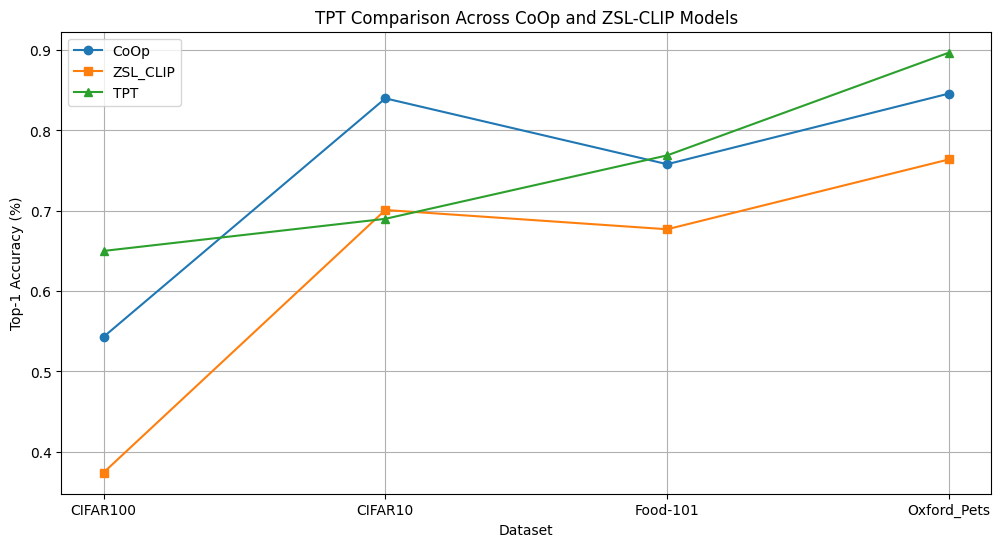

In [103]:
from matplotlib import pyplot as plt

# Updated data
CoOp = [0.543, 0.84, 0.758, 0.846]
ZSL_CLIP = [0.374, 0.701, 0.677, 0.764]
TPT = [0.65, 0.69, 0.769, 0.897]
datasets_ = ['CIFAR100', 'CIFAR10', 'Food-101', 'Oxford_Pets']

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(datasets_, CoOp, marker='o', label='CoOp')
plt.plot(datasets_, ZSL_CLIP, marker='s', label='ZSL_CLIP')
plt.plot(datasets_, TPT, marker='^', label='TPT')

plt.title('TPT Comparison Across CoOp and ZSL-CLIP Models')
plt.xlabel('Dataset')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()

### 2. TPT Performance Comparison with CLIP Models

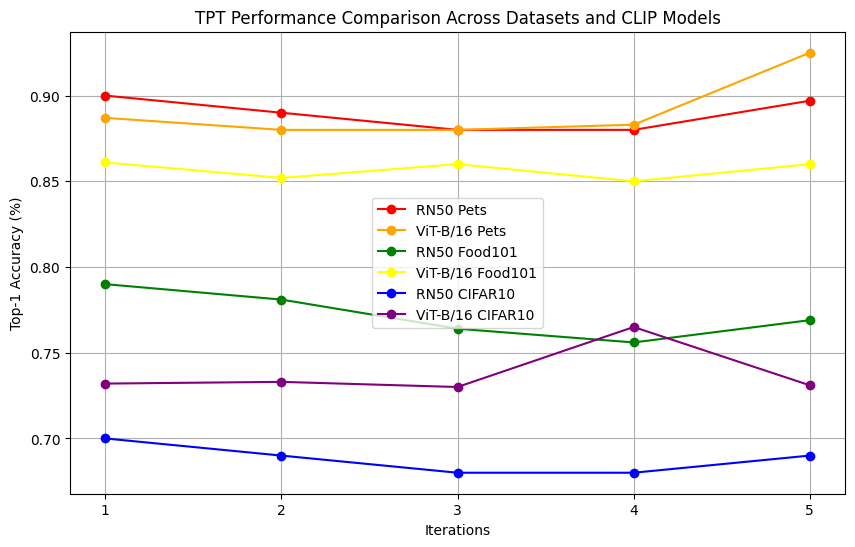

In [105]:
model1 = "CLIP-RN50"
oxford_pet_acc_clip_rn50 = [0.90, 0.89, 0.88, 0.88, 0.897]
food101_acc_clip_rn50 = [0.790, 0.781, 0.764, 0.756, 0.769]
cifar_acc_clip_rn50 = [0.70, 0.69, 0.68, 0.68, 0.69]


model2 = "CLIP-ViT-B/16"
oxford_pet_acc_clip_vit16 = [0.887, 0.880, 0.880, 0.883, 0.925]
food101_acc_clip_vit16 = [0.861, 0.852, 0.860, 0.85, 0.86]
cifar10_acc_clip_vit16 = [0.732, 0.733, 0.730, 0.765, 0.731]

NUM_EPOCHS = 5

# Epochs range
n_epochs = range(1, NUM_EPOCHS + 1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_epochs, oxford_pet_acc_clip_rn50, marker='o', label='RN50 Pets', color='red')
plt.plot(n_epochs, oxford_pet_acc_clip_vit16, marker='o', label='ViT-B/16 Pets', color='orange')

plt.plot(n_epochs, food101_acc_clip_rn50, marker='o', label='RN50 Food101', color='green')
plt.plot(n_epochs, food101_acc_clip_vit16, marker='o', label='ViT-B/16 Food101', color='yellow')

plt.plot(n_epochs, cifar_acc_clip_rn50, marker='o', label='RN50 CIFAR10', color='blue')
plt.plot(n_epochs, cifar10_acc_clip_vit16, marker='o', label='ViT-B/16 CIFAR10', color='purple')

plt.title('TPT Performance Comparison Across Datasets and CLIP Models')
plt.xlabel('Iterations')
plt.ylabel('Top-1 Accuracy (%)')
plt.xticks(n_epochs)
plt.legend()
plt.grid(True)
plt.show()

### 3. TPT Experiments with Diff. Hyperparameters

In [89]:
import argparse
import os

# clip_backbones = ['RN50', 'ViT-B/16']
clip_backbones = ['ViT-B/16']

pretrained_models = {
    'ViT-B/16-xctx4-seed0': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx4-seed1': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx4-seed2': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed2.pth',
    'ViT-B/16-xctx4-seed3': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed3.pth',
    'ViT-B/16-xctx8-seed0': 'models/vit_b16_ep50_16shotsnctx8_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx8-seed1': 'models/vit_b16_ep50_16shotsnctx8_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx8-seed2': 'models/vit_b16_ep50_16shotsnctx8_cscFalse_ctpendseed2.pth',
    'ViT-B/16-xctx8-seed3': 'models/vit_b16_ep50_16shotsnctx8_cscFalse_ctpendseed3.pth',
    'ViT-B/16-xctx16-seed0': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx16-seed1': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'ViT-B/16-xctx16-seed2': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed2.pth',
    'ViT-B/16-xctx16-seed3': 'models/vit_b16_ep50_16shotsnctx4_cscFalse_ctpendseed3.pth',
    'RN50-xctx4-seed0': 'models/rn50_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'RN50-xctx4-seed1': 'models/rn50_ep50_16shotsnctx4_cscFalse_ctpendseed1.pth',
    'RN50-xctx4-seed2': 'models/rn50_ep50_16shotsnctx4_cscFalse_ctpendseed2.pth',
    'RN50-xctx4-seed3': 'models/rn50_ep50_16shotsnctx4_cscFalse_ctpendseed3.pth',
    'RN50-xctx8-seed0': 'models/rn50_ep50_16shotsnctx8_cscFalse_ctpendseed1.pth',
    'RN50-xctx8-seed1': 'models/rn50_ep50_16shotsnctx8_cscFalse_ctpendseed1.pth',
    'RN50-xctx8-seed2': 'models/rn50_ep50_16shotsnctx8_cscFalse_ctpendseed2.pth',
    'RN50-xctx8-seed3': 'models/rn50_ep50_16shotsnctx8_cscFalse_ctpendseed3.pth',
    'RN50-xctx16-seed0': 'models/rn50_ep50_16shotsnctx16_cscFalse_ctpendseed1.pth',
    'RN50-xctx16-seed1': 'models/rn50_ep50_16shotsnctx16_cscFalse_ctpendseed1.pth',
    'RN50-xctx16-seed2': 'models/rn50_ep50_16shotsnctx16_cscFalse_ctpendseed2.pth',
    'RN50-xctx16-seed3': 'models/rn50_ep50_16shotsnctx16_cscFalse_ctpendseed3.pth',
}

exp_datasets = ['Pets', 'Food101', 'CIFAR10']
# exp_datasets = ['Pets']

hyper_param_configs = [
    # tta_steps (iterations): More iterations lead to better adaptation but may also increase the risk of over-fitting to the test set
    {'tta_steps': 2, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    {'tta_steps': 4, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    
    # more tunable tokens increase the model's flexibility and capacity to adapt. However, too many tunable tokens may lead to over-fitting, especially with limited test data or a small number of adaptation steps.
    {'tta_steps': 1, 'n_ctx': 8, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    {'tta_steps': 1, 'n_ctx': 16, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    
    # More augmented views increase the model's capacity to adapt. However, too many views might introduce noise or irrelevant variations, potentially hampering the model's ability to generalize.
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 128, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 256, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    
    # higher means using more data points (including less confident ones), which can lead to more generalized learning but may include noisy or incorrect labels.
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.3, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.5, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.7, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 0},
    
    # The batch size determines the number of views that are used for adaptation. A higher batch size leads to more views being selected, which increases the model's capacity to adapt.
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 128, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 128, 'seed': 0},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 256, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 256, 'seed': 0},
    
    # The random seed determines the random initialization of the model's tunable tokens.
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 1},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 2},
    {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 64, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 64, 'seed': 3},
]


def run_experiments(hyper_param_configs_, backbones_, dataset_):
    # Iterate over different hyperparameter configurations
    for config in hyper_param_configs_:
        logger.info("Running experiment with hyperparameters: {}".format(config))
        # Update the argparse arguments
        args = update_arguments(config, backbones_, dataset_)
        
        # Call the tpt_classification function with the updated arguments
        tpt_classification(args)
        
        logger.info("\n")
        logger.info("*" * 50)
        logger.info("\n")

def update_arguments(config, backbone_, dataset_):
    # Create a new argparse instance for each experiment
    parser = argparse.ArgumentParser(description='Test-time Prompt Tuning')
    parser.add_argument('--data', metavar='DIR', default='DATA/', help='path to dataset root')
    parser.add_argument('--test_sets', type=str, default=dataset_, help='test dataset (multiple datasets split by slash)')
    parser.add_argument('--dataset_mode', type=str, default='test', help='which split to use: train/val/test')
    
    parser.add_argument('-a', '--arch', metavar='ARCH', default=backbone_)
    parser.add_argument('--resolution', default=224, type=int, help='CLIP image resolution')
    parser.add_argument('-j', '--workers', default=4, type=int, metavar='N',
                        help='number of data loading workers (default: 4)')
    parser.add_argument('-b', '--batch-size', default=config['batch-size'], type=int, metavar='N')
    parser.add_argument('--lr', '--learning-rate', default=config['learning-rate'], type=float,
                        metavar='LR', help='initial learning rate', dest='lr')
    parser.add_argument('-p', '--print-freq', default=200, type=int,
                        metavar='N', help='print frequency (default: 10)')
    parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
    parser.add_argument('--tpt', action='store_true', default=True, help='run test-time prompt tuning')
    parser.add_argument('--augmented_views', default=config['augmented_views'], type=int, 
                        help='number of augmented views (normally equals to batch size)')
    parser.add_argument('--selection_p', default=config['selection_p'], type=float, 
                        help='confidence selection percentile')
    parser.add_argument('--tta_steps', default=config['tta_steps'], type=int, help='test-time-adapt steps')
    parser.add_argument('--n_ctx', default=config['n_ctx'], type=int, help='number of tunable tokens')
    parser.add_argument('--ctx_init', default=None, type=str, help='init tunable prompts')
    parser.add_argument('--cocoop', action='store_true', default=False, 
                        help="use cocoop output as prompt initialization")
    
    if backbone_ == "ViT-B/16":
        parser.add_argument(
            '--pretrained_model',
            default=pretrained_models["ViT-B/16-xctx{}-seed{}".format(config['n_ctx'], config['seed'])],
            type=str, help='path to a pre-trained coop/cocoop'
        )
    elif backbone_ == "RN50":
        parser.add_argument(
            '--pretrained_model',
            default=pretrained_models["ViT-B/16-xctx{}-seed{}".format(config['n_ctx'], config['seed'])],
            type=str, help='path to a pre-trained coop/cocoop'
        )
    else:
        raise ValueError("Unsupported model architecture: {}".format(backbone_))
    
    parser.add_argument('--seed', type=int, default=config['seed'])
    parser.add_argument('-f')
    
    args_ = parser.parse_args()
    
    return args_


for clip_backbone in clip_backbones:
    for dataset in exp_datasets:
        logger.info("Running experiments for {} on {} at Date: ".format(clip_backbone, dataset, time.ctime()))
        run_experiments(hyper_param_configs, clip_backbone, dataset)

INFO:tpt_classification:Running experiments for ViT-B/16 on Pets at Date: 
INFO:tpt_classification:Running experiment with hyperparameters: {'tta_steps': 1, 'n_ctx': 4, 'augmented_views': 128, 'selection_p': 0.1, 'learning-rate': 0.005, 'batch-size': 128, 'seed': 0}
INFO:tpt_classification:Use GPU: 0 for training
INFO:tpt_classification:Random initialization: initializing a generic context
INFO:tpt_classification:Initial context: "X X X X"
INFO:tpt_classification:Number of context words (tokens): 4
INFO:tpt_classification:Use pre-trained soft prompt (CoOp) as initialization
INFO:tpt_classification:=> Model created: visual backbone ViT-B/16
INFO:tpt_classification:=> Using native Torch AMP. Training in mixed precision.
INFO:tpt_classification:evaluating: Pets
INFO:tpt_classification:number of test samples: 3669
INFO:tpt_classification:Test: [ 199/3669]	Time  0.613 ( 0.622)	Acc@1 100.00 ( 88.50)	Acc@5 100.00 ( 95.50)
INFO:tpt_classification:Test: [ 399/3669]	Time  0.613 ( 0.618)	Acc@1 10

KeyboardInterrupt: 

## Detained Analysis on Hyperparameters

### A. Playing with 'selection_p' 
Experimenting with 'selection_p' by changing it 0.5 and 0.7

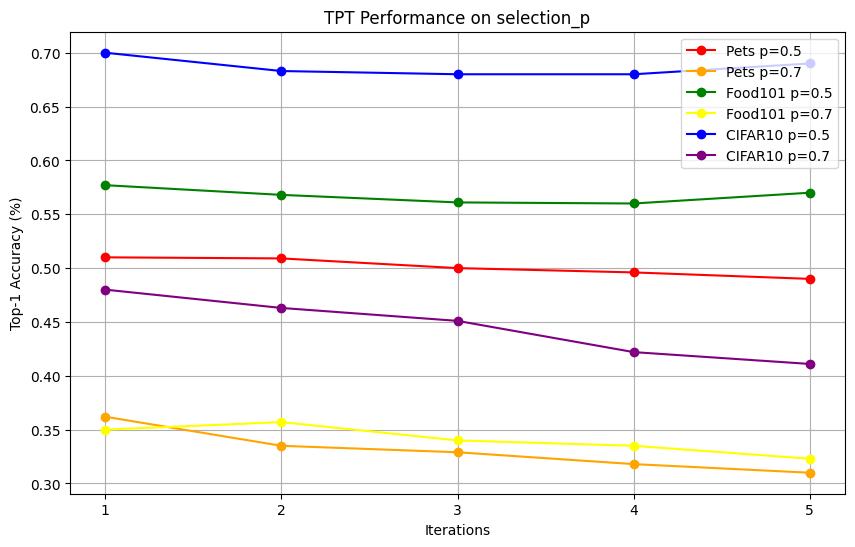

In [5]:
from matplotlib import pyplot as plt

oxford_pet_acc_selection_p_5 = [0.51, 0.509, 0.50, 0.496, 0.49]
food101_acc_selection_p_5 = [0.577, 0.5680, 0.5610, 0.56, 0.57]
cifar_acc_selection_p_5 = [0.70, .683, 0.68, 0.68, 0.69]

oxford_pet_acc_selection_p_7 = [0.362, 0.335, 0.329, 0.318, 0.310]
food101_acc_selection_p_7 = [0.350, 0.357, 0.340, 0.335, 0.323]
cifar_acc_selection_p_7 = [0.48, .463, 0.451, 0.422, 0.411]

# draw the plot 
NUM_EPOCHS = 5

# Epochs range
n_epochs = range(1, NUM_EPOCHS + 1)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(n_epochs, oxford_pet_acc_selection_p_5, marker='o', label='Pets p=0.5', color='red')
plt.plot(n_epochs, oxford_pet_acc_selection_p_7, marker='o', label='Pets p=0.7', color='orange')

plt.plot(n_epochs, food101_acc_selection_p_5, marker='o', label='Food101 p=0.5', color='green')
plt.plot(n_epochs, food101_acc_selection_p_7, marker='o', label='Food101 p=0.7', color='yellow')

plt.plot(n_epochs, cifar_acc_selection_p_5, marker='o', label='CIFAR10 p=0.5', color='blue')
plt.plot(n_epochs, cifar_acc_selection_p_7, marker='o', label='CIFAR10 p=0.7', color='purple')

plt.title('TPT Performance on selection_p')
plt.xlabel('Iterations')
plt.ylabel('Top-1 Accuracy (%)')
plt.xticks(n_epochs)
plt.legend()
plt.grid(True)
plt.show()

## 

# B. Playing with 'augmented_views' 
Experimenting with 'augmented_views' by changing it 128 and 256

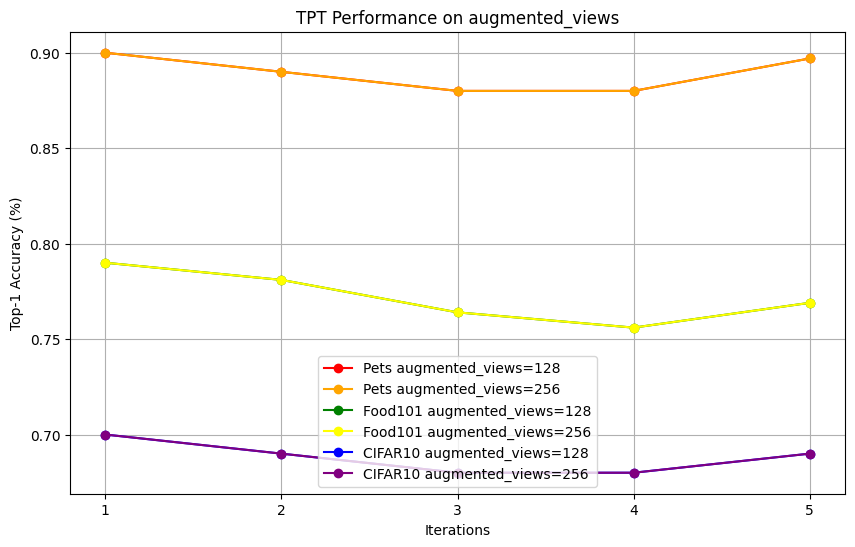

In [1]:
from matplotlib import pyplot as plt

oxford_pet_acc_augmented_views_128 = [0.90, 0.89, 0.88, 0.88, 0.897]
food101_acc_augmented_views_128 = [0.790, 0.781, 0.764, 0.756, 0.769]
cifar_acc_augmented_views_128 = [0.70, 0.69, 0.68, 0.68, 0.69]

oxford_pet_acc_augmented_views_256 = [0.90, 0.89, 0.88, 0.88, 0.897]
food101_acc_augmented_views_256 = [0.790, 0.781, 0.764, 0.756, 0.769]
cifar_acc_augmented_views_256 = [0.70, 0.69, 0.68, 0.68, 0.69]

# draw the plot
NUM_EPOCHS = 5

# Epochs range
n_epochs = range(1, NUM_EPOCHS + 1)

# Plotting the results
plt.figure(figsize=(10, 6))

plt.plot(n_epochs, oxford_pet_acc_augmented_views_128, marker='o', label='Pets augmented_views=128', color='red')
plt.plot(n_epochs, oxford_pet_acc_augmented_views_256, marker='o', label='Pets augmented_views=256', color='orange')

plt.plot(n_epochs, food101_acc_augmented_views_128, marker='o', label='Food101 augmented_views=128', color='green')
plt.plot(n_epochs, food101_acc_augmented_views_256, marker='o', label='Food101 augmented_views=256', color='yellow')

plt.plot(n_epochs, cifar_acc_augmented_views_128, marker='o', label='CIFAR10 augmented_views=128', color='blue')
plt.plot(n_epochs, cifar_acc_augmented_views_256, marker='o', label='CIFAR10 augmented_views=256', color='purple')

plt.title('TPT Performance on augmented_views')
plt.xlabel('Iterations')
plt.ylabel('Top-1 Accuracy (%)')

plt.xticks(n_epochs)
plt.legend()
plt.grid(True)
plt.show()

## BongardHOI Visual-Reasoning Understanding

In [ ]:
# %cd /root/

# HOME = os.getcwd()

# %cd /root/DATA/

data_dir = os.getcwd()

# download the dataset


# 4. TPT Experiments with Diff.TPT

## DiffTPT Classification

### ImageNet Dataset

In [109]:
!pip install huggingface_hub
!pip install datasets pillow
!huggingface-cli login --token "hugging_face_token"

  Using cached datasets-2.15.0-py3-none-any.whl.metadata (20 kB)
  Using cached pyarrow_hotfix-0.6-py3-none-any.whl.metadata (3.6 kB)
  Using cached dill-0.3.7-py3-none-any.whl.metadata (9.9 kB)
  Using cached huggingface_hub-0.19.4-py3-none-any.whl.metadata (14 kB)
  Using cached aiosignal-1.3.1-py3-none-any.whl (7.6 kB)
Using cached datasets-2.15.0-py3-none-any.whl (521 kB)
Using cached dill-0.3.7-py3-none-any.whl (115 kB)
   ---------------------------------------- 0.0/364.8 kB ? eta -:--:--
   ------ --------------------------------- 61.4/364.8 kB 3.2 MB/s eta 0:00:01
   ----------------- ---------------------- 163.8/364.8 kB 2.0 MB/s eta 0:00:01
   --------------------- ------------------ 194.6/364.8 kB 2.0 MB/s eta 0:00:01
   ----------------------------------- ---- 327.7/364.8 kB 2.0 MB/s eta 0:00:01
   ---------------------------------------- 364.8/364.8 kB 1.9 MB/s eta 0:00:00
Using cached huggingface_hub-0.19.4-py3-none-any.whl (311 kB)
   ------------------------------------

In [30]:
import os
from PIL import Image
from torchvision import transforms
from datasets import load_dataset

In [110]:
!pip install datasets

In [31]:
imagenet_dataset = load_dataset("imagenet-1k")

In [32]:
imagenet_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 1281167
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 50000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 100000
    })
})

In [33]:
imagenet_features = imagenet_dataset['test'].features

# Retrieve the class names
# This depends on how the class names are stored in the dataset's features
imagenet_classes = imagenet_features['label'].names if 'names' in dir(imagenet_features['label']) else None
imagenet_classes

['tench, Tinca tinca',
 'goldfish, Carassius auratus',
 'great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias',
 'tiger shark, Galeocerdo cuvieri',
 'hammerhead, hammerhead shark',
 'electric ray, crampfish, numbfish, torpedo',
 'stingray',
 'cock',
 'hen',
 'ostrich, Struthio camelus',
 'brambling, Fringilla montifringilla',
 'goldfinch, Carduelis carduelis',
 'house finch, linnet, Carpodacus mexicanus',
 'junco, snowbird',
 'indigo bunting, indigo finch, indigo bird, Passerina cyanea',
 'robin, American robin, Turdus migratorius',
 'bulbul',
 'jay',
 'magpie',
 'chickadee',
 'water ouzel, dipper',
 'kite',
 'bald eagle, American eagle, Haliaeetus leucocephalus',
 'vulture',
 'great grey owl, great gray owl, Strix nebulosa',
 'European fire salamander, Salamandra salamandra',
 'common newt, Triturus vulgaris',
 'eft',
 'spotted salamander, Ambystoma maculatum',
 'axolotl, mud puppy, Ambystoma mexicanum',
 'bullfrog, Rana catesbeiana',
 'tree frog, tree-f

In [111]:
len(imagenet_classes)

NameError: name 'imagenet_classes' is not defined

In [35]:
class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, split='train', transform=None):
        self.dataset = huggingface_dataset[split]
        self.transform = transform

    def __getitem__(self, index):
        # Load an image and its label from the Hugging Face dataset
        img, class_idx = self.dataset[index]['image'], self.dataset[index]['label']
        
        # Convert to RGB if not already
        if img.mode != 'RGB':
            img = img.convert('RGB')
        
        # Apply the transform if any
        if self.transform:
            img = self.transform(img)
            if img.shape[0] == 4:  # Handling RGBA images
                img = img[1:]

        return img, class_idx

    def __len__(self):
        return len(self.dataset)

In [36]:
# Augment train data
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    #transforms.RandomHorizontalFlip(p=0.5),
    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.ToTensor()
])

In [37]:
# Create dataset instances
imagenet_train_dataset = ImageNetDataset(imagenet_dataset, split='train', transform=transform)
imagenet_val_dataset = ImageNetDataset(imagenet_dataset, split='validation', transform=transform)
# imagenet_test_dataset = ImageNetDataset(imagenet_dataset, split='test', transform=transform)

In [38]:
# Create data loaders
batch_size = 32
imagenet_train_loader = DataLoader(imagenet_train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
imagenet_val_loader = DataLoader(imagenet_val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
# imagenet_test_loader = DataLoader(imagenet_test_dataset, batch_size=batch_size)

In [39]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(imagenet_train_loader))

print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label_custom.shape}")
print(f"label value: {label_custom}")

Image shape: torch.Size([32, 3, 224, 224]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([32])
label value: tensor([532, 138, 249, 658, 847, 535, 841, 792, 365, 499, 337, 297, 822, 207,
        396, 449, 931, 515, 229, 588, 883, 694, 894, 215,  20,  24, 505, 459,
        922, 907, 132, 711])


In [39]:
import numpy as np
from PIL import Image

try:
    from torchvision.transforms import InterpolationMode
    BICUBIC = InterpolationMode.BICUBIC
except ImportError:
    BICUBIC = Image.BICUBIC

# from data.imagenet_variants import thousand_k_to_200, imagenet_a_mask, imagenet_r_mask, imagenet_v_mask, imagenet_r_fold
imagenet_r_fold = ['n01443537', 'n01484850', 'n01494475', 'n01498041', 'n01514859', 'n01518878', 'n01531178', 'n01534433', 'n01614925', 'n01616318', 'n01630670', 'n01632777', 'n01644373', 'n01677366', 'n01694178', 'n01748264', 'n01770393', 'n01774750', 'n01784675', 'n01806143', 'n01820546', 'n01833805', 'n01843383', 'n01847000', 'n01855672', 'n01860187', 'n01882714', 'n01910747', 'n01944390', 'n01983481', 'n01986214', 'n02007558', 'n02009912', 'n02051845', 'n02056570', 'n02066245', 'n02071294', 'n02077923', 'n02085620', 'n02086240', 'n02088094', 'n02088238', 'n02088364', 'n02088466', 'n02091032', 'n02091134', 'n02092339', 'n02094433', 'n02096585', 'n02097298', 'n02098286', 'n02099601', 'n02099712', 'n02102318', 'n02106030', 'n02106166', 'n02106550', 'n02106662', 'n02108089', 'n02108915', 'n02109525', 'n02110185', 'n02110341', 'n02110958', 'n02112018', 'n02112137', 'n02113023', 'n02113624', 'n02113799', 'n02114367', 'n02117135', 'n02119022', 'n02123045', 'n02128385', 'n02128757', 'n02129165', 'n02129604', 'n02130308', 'n02134084', 'n02138441', 'n02165456', 'n02190166', 'n02206856', 'n02219486', 'n02226429', 'n02233338', 'n02236044', 'n02268443', 'n02279972', 'n02317335', 'n02325366', 'n02346627', 'n02356798', 'n02363005', 'n02364673', 'n02391049', 'n02395406', 'n02398521', 'n02410509', 'n02423022', 'n02437616', 'n02445715', 'n02447366', 'n02480495', 'n02480855', 'n02481823', 'n02483362', 'n02486410', 'n02510455', 'n02526121', 'n02607072', 'n02655020', 'n02672831', 'n02701002', 'n02749479', 'n02769748', 'n02793495', 'n02797295', 'n02802426', 'n02808440', 'n02814860', 'n02823750', 'n02841315', 'n02843684', 'n02883205', 'n02906734', 'n02909870', 'n02939185', 'n02948072', 'n02950826', 'n02951358', 'n02966193', 'n02980441', 'n02992529', 'n03124170', 'n03272010', 'n03345487', 'n03372029', 'n03424325', 'n03452741', 'n03467068', 'n03481172', 'n03494278', 'n03495258', 'n03498962', 'n03594945', 'n03602883', 'n03630383', 'n03649909', 'n03676483', 'n03710193', 'n03773504', 'n03775071', 'n03888257', 'n03930630', 'n03947888', 'n04086273', 'n04118538', 'n04133789', 'n04141076', 'n04146614', 'n04147183', 'n04192698', 'n04254680', 'n04266014', 'n04275548', 'n04310018', 'n04325704', 'n04347754', 'n04389033', 'n04409515', 'n04465501', 'n04487394', 'n04522168', 'n04536866', 'n04552348', 'n04591713', 'n07614500', 'n07693725', 'n07695742', 'n07697313', 'n07697537', 'n07714571', 'n07714990', 'n07718472', 'n07720875', 'n07734744', 'n07742313', 'n07745940', 'n07749582', 'n07753275', 'n07753592', 'n07768694', 'n07873807', 'n07880968', 'n07920052', 'n09472597', 'n09835506', 'n10565667', 'n12267677']

## Stable Diffusion based data augmentation

In [ ]:
import os
import torch
import argparse
from PIL import Image
from torchvision import transforms
from accelerate import Accelerator
from diffusers import StableDiffusionImageVariationPipeline
from torch.utils.data import Dataset
import random
import shutil

parser = argparse.ArgumentParser()
parser.add_argument("--batch_size", type=int, default=5)
parser.add_argument("--data_dir", type=str, default='/DATA/imagenet_r')
parser.add_argument("--save_image_gen", type=str, default='/DATA/imagenet_r_gen')
parser.add_argument("--dfu_times", type=int, default=65)
args = parser.parse_args()

accelerator = Accelerator()
os.makedirs(args.save_image_gen, exist_ok=True)


class DatasetImageNetR(Dataset):
    def __init__(self, root, transform):
        self.root = root
        self.transform = transform
        self.folders = os.listdir(self.root)
        self.folders.sort()
        self.images = []
        for folder in self.folders:
            if not os.path.isdir(os.path.join(self.root, folder)):
                continue
            class_images = os.listdir(os.path.join(self.root, folder))
            class_images = list(map(lambda x: os.path.join(folder, x), class_images))
            random.shuffle(class_images)
            class_image = class_images[0:5]
            self.images = self.images + class_image

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.transform(Image.open(os.path.join(self.root, self.images[idx])).convert('RGB'))
        return self.images[idx], image


def generate_images(pipe, dataloader, args_):
    pipe, dataloader = accelerator.prepare(pipe, dataloader)
    pipe.safety_checker = lambda images_, clip_input: (images_, False)
    pipe = pipe.to(accelerator.device)
    with torch.no_grad():
        for count, (image_locations, original_images) in enumerate(dataloader):
            logger.info(f'{count} / {len(dataloader)}, {image_locations[0]}.')

            for image_lo in image_locations:
                os.makedirs(os.path.join(args_.save_image_gen, os.path.dirname(image_lo)), exist_ok=True)
                source_path = os.path.join(args_.data_dir, image_lo)
                dist_path = os.path.join(args_.save_image_gen, image_lo)

                if not os.path.exists(dist_path):
                    shutil.copyfile(source_path, dist_path)
                    with open(os.path.join(args_.save_image_gen, 'selected_data_list.txt'), 'a+') as f:
                        f.write(dist_path + '\n')

            for time_ in range(args_.dfu_times):
                images = pipe(original_images, guidance_scale=3).images
                for index in range(len(images)):
                    images[index].save(os.path.join(args_.save_image_gen,
                                                    image_locations[index].split('.')[0] + '_' + str(time_) + '.' +
                                                    image_locations[index].split('.')[1]))


def main():
    model_name_path = "lambdalabs/sd-image-variations-diffusers"
    pipe = StableDiffusionImageVariationPipeline.from_pretrained(model_name_path, revision="v2.0")

    tform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(
            (224, 224),
            interpolation=transforms.InterpolationMode.BICUBIC,
            antialias=False,
        ),
        transforms.Normalize(
            [0.48145466, 0.4578275, 0.40821073],
            [0.26862954, 0.26130258, 0.27577711]),
    ])

    dataset_ = DatasetImageNetR(args.data_dir, tform)
    dataloader = torch.utils.data.DataLoader(dataset_, batch_size=args.batch_size, shuffle=False)
    generate_images(pipe, dataloader, args)


In [2]:
class DiffusionData(Dataset):
    def __init__(self, data_root, img_list, label_list, trains_form, augmentation_mode='diff_tpt', 
                 diffusion_ratio=0.5, view_num=63):
        self.data_root = data_root
        self.img_list = img_list
        self.label_list = label_list
        self.trains_form = trains_form
        self.augmentation_mode = augmentation_mode
        self.diffusion_ratio = diffusion_ratio
        self.view_num = view_num

    def __getitem__(self, item):
        if self.augmentation_mode == 'tpt':
            img = Image.open(self.img_list[item]).convert('RGB')
            images_ = self.trains_form[0](img)
            # return images_, self.label_list[item], self.img_list[item]
            return images_, self.label_list[item]

        elif self.augmentation_mode == 'difftpt':
            # diffusion 64 + augmentation 64
            img = Image.open(self.img_list[item]).convert('RGB')
            images_ = self.trains_form[0](img)

            diffusion_img = [] # 63 diffusion images
            for i in range(self.view_num):
                data_name = ((self.img_list[item]).split('/'))[-1]
                data_fold = ((self.img_list[item]).split('/'))[-2]
                img_i = Image.open(os.path.join(self.data_root, data_fold, 
                                                data_name[:-4]+'_'+str(i)+data_name[-4:])).convert('RGB')
                img_i = self.trains_form[1](img_i)
                diffusion_img.append(img_i)

            # return images_ + diffusion_img, self.label_list[item], self.img_list[item]
            return images_ + diffusion_img, self.label_list[item]
        else:
            logger.info('self.augmentation_mode error! tpt or diff_tpt')
            exit()

    def __len__(self):
        return len(self.img_list)

In [3]:
def get_data_loader(data_transform, args_=None):
    normalize = transforms.Normalize(mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

    data_transform_diffusion = transforms.Compose([
        transforms.Resize(args_.resolution, interpolation=BICUBIC), transforms.CenterCrop(args_.resolution),
        transforms.ToTensor(), normalize,
    ])
    
    img_list = []
    label_list = []
    with open(os.path.join(args_.diff_root, 'selected_data_list.txt'), 'r') as f:
        for line in f.readlines():
            read_img = line.strip()
            img_list.append(read_img)
            label_list.append(imagenet_r_fold.index(read_img.split('/')[-2]))

    tpt_dataset = DiffusionData(
        data_root=args_.diff_root, img_list=img_list, label_list=label_list, 
        trains_form=[data_transform, data_transform_diffusion], augmentation_mode=args_.aug_mode, 
        view_num=args_.batch_size - 1
    )

    return tpt_dataset

In [4]:
def select_confident_samples_cosine(logits, selection_cosine, selection_self_entro):
    cosine_distance = [torch.nn.CosineSimilarity(dim=0)(logits[0], logits[i]) for i in range(1, logits.shape[0])]
    cosine_distance = torch.stack(cosine_distance)
    idx_cosine = torch.argsort(cosine_distance, descending=True)[:int(cosine_distance.size()[0] * selection_cosine)]
    
    # idx
    for i in range(idx_cosine.shape[0]):
        idx_cosine[i] +=1
    
    logits_cos = logits[idx_cosine]
    logits = torch.cat((logits[0, :].unsqueeze(0), logits_cos), dim=0)

    batch_entropy = -(logits.softmax(1) * logits.log_softmax(1)).sum(1)
    idx = torch.argsort(batch_entropy, descending=False)[:int(batch_entropy.size()[0] * selection_self_entro)]

    return logits[idx], [idx_cosine, idx], cosine_distance

In [5]:
def test_time_tuning_diff_tpt(model, inputs, optimizer, scaler, args_):
    if args_.cocoop:
        image_feature, pgen_ctx = inputs
        pgen_ctx.requires_grad = True
        optimizer = torch.optim.AdamW([pgen_ctx], args_.lr)

    selected_idx = None
    image_feature = None
    pgen_ctx = None
    
    for j in range(args_.tta_steps):
        with torch.cuda.amp.autocast():
            if args_.cocoop:
                output = model((image_feature, pgen_ctx))
            else:
                output = model(inputs) 

            if selected_idx is not None:
                logits_cos = output[selected_idx[0]]
                logits = torch.cat((output[0, :].unsqueeze(0), logits_cos), dim=0)
                output = logits[selected_idx[1]]
            else:
                output, selected_idx, batch_entropy = select_confident_samples_cosine(output, args_.selection_cosine, args_.selection_selfentro)

            loss = avg_entropy(output)

        optimizer.zero_grad()
        
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        
        # Unscales the gradients of optimizers assigned params in-place
        scaler.step(optimizer)
        scaler.update()

    if args_.cocoop:
        return pgen_ctx

    return

In [6]:
def tpt_test_time_tuning(model, inputs, optimizer, scaler, args_):
    image_feature = None
    pgen_ctx = None
    
    if args_.cocoop:
        image_feature, pgen_ctx = inputs
        pgen_ctx.requires_grad = True
        optimizer = torch.optim.AdamW([pgen_ctx], args_.lr)
    
    selected_idx = None
    for j in range(args_.tta_steps):
        with torch.cuda.amp.autocast():
            if args_.cocoop:
                output = model((image_feature, pgen_ctx))
            else:
                output = model(inputs) 

            if selected_idx is not None:
                output = output[selected_idx]
            else:
                output, selected_idx = select_confident_samples(output, args_.selection_p)

            loss = avg_entropy(output)
        
        optimizer.zero_grad()
        
        # compute gradient and do SGD step
        scaler.scale(loss).backward()
        
        # Unscales the gradients of optimizers assigned params in-place
        scaler.step(optimizer)
        scaler.update()
    if args_.cocoop:
        return pgen_ctx
    
    return

In [7]:
def diff_tpt_test_time_adapt_eval(val_loader, model, model_state, optimizer, optim_state, scaler, args_):
    image_feature = None
    pgen_ctx = None
    
    batch_time = AverageMeter('Time', ':6.3f', Summary.NONE)
    top1 = AverageMeter('Acc@1', ':6.2f', Summary.AVERAGE)
    top5 = AverageMeter('Acc@5', ':6.2f', Summary.AVERAGE)
    
    progress = ProgressMeter(len(val_loader),[batch_time, top1, top5], prefix='Test: ')

    # reset model and switch to evaluate mode
    model.eval()
    if not args_.cocoop: # no need to reset cocoop because it's fixed
        with torch.no_grad():
            model.reset()
    
    # reset the tunable prompt to its initial state
    end = time.time()
    for i, (images, target) in enumerate(val_loader):
        assert args_.gpu is not None
        if isinstance(images, list):
            for k in range(len(images)):
                images[k] = images[k].cuda(args_.gpu, non_blocking=True)
            image = images[0]
        else:
            if len(images.size()) > 4:
                # when using ImageNet Sampler as the dataset
                assert images.size()[0] == 1
                images = images.squeeze(0)
            images = images.cuda(args_.gpu, non_blocking=True)
            image = images
        target = target.cuda(args_.gpu, non_blocking=True)
        if args_.tpt:
            images = torch.cat(images, dim=0)

        # reset the tunable prompt to its initial state
        if not args_.cocoop: # no need to reset cocoop because it's fixed
            if args_.tta_steps > 0:
                with torch.no_grad():
                    model.reset()
            optimizer.load_state_dict(optim_state)
            if args_.aug_mode == 'tpt':
                tpt_test_time_tuning(model, images, optimizer, scaler, args_)
            elif args_.aug_mode == 'difftpt':
                test_time_tuning_diff_tpt(model, images, optimizer, scaler, args_)
        else:
            with torch.no_grad():
                with torch.cuda.amp.autocast():
                    image_feature, pgen_ctx = model.gen_ctx(images, args_.tpt)
            optimizer = None
            if args_.aug_mode == 'tpt':
                pgen_ctx = tpt_test_time_tuning(model, (image_feature, pgen_ctx), optimizer, scaler, args_)
            elif args_.aug_mode == 'difftpt':
                pgen_ctx = test_time_tuning_diff_tpt(model, (image_feature, pgen_ctx), optimizer, scaler, args_)
                
        # The actual inference goes here
        if args_.tpt:
            if args_.cocoop:
                image_feature = image_feature[0].unsqueeze(0)
        
        with torch.no_grad():
            with torch.cuda.amp.autocast():
                if args_.cocoop:
                    output = model((image_feature, pgen_ctx))
                else:
                    output = model(image)
                    
        # measure accuracy and record loss
        acc1, acc5 = accuracy(output, target, topk=(1, 5))
        
        # measure accuracy and record loss
        top1.update(acc1[0], image.size(0))
        top5.update(acc5[0], image.size(0))
        
        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if (i+1) % args_.print_freq == 0:
            progress.display(i)
    
    progress.display_summary()

    return [top1.avg, top5.avg]

In [8]:
def diff_tpt_classification(args_):
    random.seed(args_.seed)
    np.random.seed(args_.seed)
    torch.manual_seed(args_.seed)
    torch.cuda.manual_seed_all(args_.seed)
    logger.info("Use GPU: {} for training".format(args_.gpu))

    if args_.cocoop:
        model = get_cocoop(args_.arch, args_.test_sets, 'cpu', args_.n_ctx)
        assert args_.pretrained is not None
        load_model_weight(args_.pretrained, model, 'cpu', args_) # to load to cuda: device="cuda:{}".format(args.gpu)
        model_state = deepcopy(model.state_dict())
    else:
        model = get_coop(args_.arch, args_.test_sets, args_.gpu, args_.n_ctx, args_.ctx_init)
        if args_.pretrained is not None:
            logger.info("Use pre-trained soft prompt (CoOp) as initialization")
            pretrained_ctx = torch.load(args_.pretrained)['state_dict']['ctx']
            assert pretrained_ctx.size()[0] == args_.n_ctx
            with torch.no_grad():
                model.prompt_learner.ctx.copy_(pretrained_ctx)
                model.prompt_learner.ctx_init_state = pretrained_ctx
                
        model_state = None

    for name, param in model.named_parameters():
        if not args_.cocoop:
            if "prompt_learner" not in name:
                param.requires_grad_(False)
        else:
            if "text_encoder" not in name:
                param.requires_grad_(False)
    
    logger.info("=> Model created: visual backbone {}".format(args_.arch))
    
    torch.cuda.set_device(args_.gpu)
    model = model.cuda(args_.gpu)
    
    # define optimizer
    if args_.cocoop:
        optimizer = None
        optim_state = None
    else:
        trainable_param = model.prompt_learner.parameters()
        optimizer = torch.optim.AdamW(trainable_param, args_.lr)
        optim_state = deepcopy(optimizer.state_dict())
        
    # Setup automatic mixed-precision (Amp) loss scaling
    scaler = torch.cuda.amp.GradScaler(init_scale=1000)
    
    logger.info("=> Training in mixed precision")

    cudnn.benchmark = True

    # norm stats from clip.load()
    normalize = transforms.Normalize(
        mean=[0.48145466, 0.4578275, 0.40821073], std=[0.26862954, 0.26130258, 0.27577711])

    # iterating through eval datasets
    data_sets_ = args_.test_sets.split("/")
    results = {}
    for set_id in data_sets_:
        if args_.tpt:
            base_transform = transforms.Compose(
                [transforms.Resize(args_.resolution, interpolation=BICUBIC), 
                 transforms.CenterCrop(args_.resolution)])
            
            preprocess = transforms.Compose([transforms.ToTensor(), normalize])
            
            data_transform = AugMixAugmenter(base_transform, preprocess, n_views=args_.batch_size,
                                             is_augmentation_mix=len(set_id)>1)
            batch_size_ = 1
        else:
            data_transform = transforms.Compose(
                [transforms.Resize(args_.resolution, interpolation=BICUBIC), 
                 transforms.CenterCrop(args_.resolution),
                 transforms.ToTensor(), normalize]
            )
            batch_size_ = args_.batch_size

        logger.info("evaluating: {}".format(set_id))
        # reset the model
        # Reset classnames of custom CLIP model
        # fine-grained classification datasets
        classnames = eval("{}_classes".format(set_id.lower()))
        
        if args_.cocoop:
            model.prompt_generator.reset_classnames(classnames, args_.arch)
            model = model.cpu()
            model_state = model.state_dict()
            model = model.cuda(args_.gpu)
        else:
            model.reset_classnames(classnames, args_.arch)

        # val_dataset = build_dataset(set_id, data_transform, args.data, mode=args.dataset_mode)
        val_dataset = get_data_loader(data_transform, args_)
        
        logger.info("number of test samples: {}".format(len(val_dataset)))
        val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size_,
                                                 shuffle=True, num_workers=args_.workers, pin_memory=True)
            
        results[set_id] = test_time_adapt_eval(val_loader, model, optimizer, scaler, args_)
        
        del val_dataset, val_loader
        
        try:
            logger.info(
                "=> Acc. on test_set [{}]: @1 {}/ @5 {}".format(set_id, results[set_id][0], results[set_id][1]))
        except Exception:
            logger.info("=> Acc. on test_set [{}]: {}".format(set_id, results[set_id]))

    logger.info("params: n_step	lr	bs")
    logger.info("params: {}	{}	{}".format(args_.tta_steps, args_.lr, args_.batch_size))
    logger.info("=> Acc. on test_set [{}]: @1 {}/ @5 {}".format(args_.test_sets, results[args_.test_sets][0], results[args_.test_sets][1]))
    logger.info("\t\t [set_id] \t\t Top-1 acc. \t\t Top-5 acc.")
    
    for id_ in results.keys():
        logger.info("{} \t\t {:.2f} \t\t {:.2f}".format(id_, results[id_][0], results[id_][1]))
    
    logger.info("\n")
    
    for id_ in results.keys():
        logger.info("{} \t\t {:.2f} \t\t {:.2f}".format(id_, results[id_][0], results[id_][1]))
    
    logger.info("\n")

In [ ]:
parser = argparse.ArgumentParser(description='Test-time Prompt Tuning')
parser.add_argument('--data', metavar='DIR', default='DATA', help='path to dataset root')
parser.add_argument('--test_sets', type=str, default='R', 
                    help='test dataset (multiple datasets split by slash)')
parser.add_argument('--dataset_mode', type=str, default='test', help='which split to use: train/val/test')
parser.add_argument('--arch', metavar='ARCH', default='RN50')
parser.add_argument('--resolution', default=224, type=int, help='CLIP image resolution')
parser.add_argument('--workers', default=4, type=int, metavar='N', 
                    help='number of data loading workers (default: 4)')
parser.add_argument('-b', '--batch-size', default=64, type=int, metavar='N')
parser.add_argument('--lr', '--learning-rate', default=5e-3, type=float, metavar='LR', dest='lr')
parser.add_argument('-p', '--print-freq', default=200, type=int, metavar='N', 
                    help='print frequency (default: 10)')
parser.add_argument('--gpu', default=0, type=int, help='GPU id to use.')
parser.add_argument('--tpt', action='store_true', default=False, help='run test-time prompt tuning')
parser.add_argument('--selection_p', default=0.1, type=float, help='confidence selection percentile')
parser.add_argument('--tta_steps', default=4, type=int, help='test-time-adapt steps')
parser.add_argument('--n_ctx', default=4, type=int, help='number of tunable tokens')
parser.add_argument('--ctx_init', default="a_photo_of_a", type=str, help='init tunable prompts')
parser.add_argument('--cocoop', action='store_true', default=False, 
                    help="use co_coop output as prompt initialization")
parser.add_argument('--pretrained', default=None, type=str, help='path to a pre-trained coop/cocoop')
parser.add_argument('--seed', type=int, default=0)
parser.add_argument('--aug_mode', default='difftpt', type=str, help='tpt or diff_tpt')
parser.add_argument('--diff_root', type=str, default="DATA/oxford_pets/images", help='SD generate img root')
parser.add_argument('--selection_cosine', default=0.8, type=float, help='confidence selection percentile')
parser.add_argument('--selection_self_entro', default=0.3, type=float, help='confidence selection percentile')

parser.add_argument('-f')

args = parser.parse_args()

diff_tpt_classification(args)

logger.info("=> Model created: visual backbone {}".format(args.arch))

## DiffTPT Performance Analysis

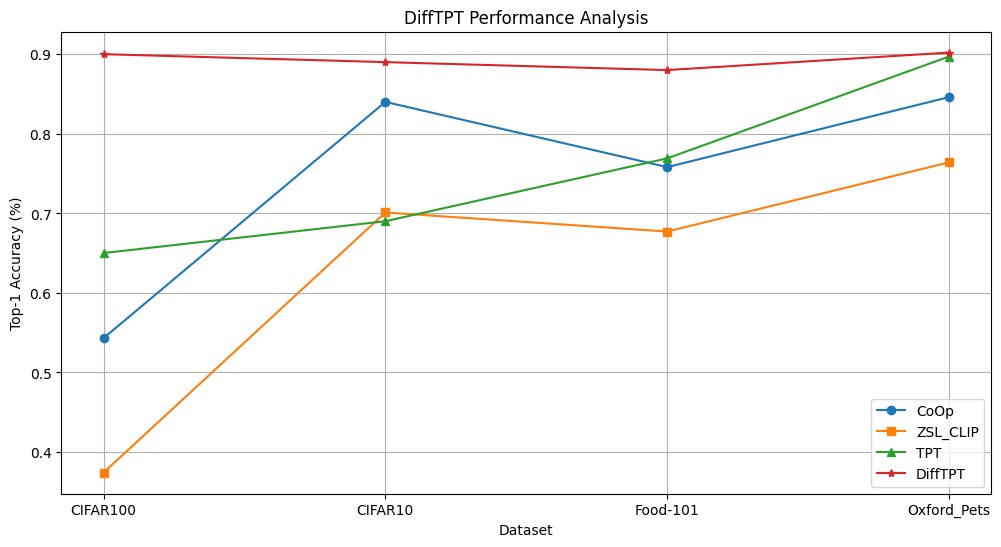

In [1]:
from matplotlib import pyplot as plt

# Data
CoOp = [0.543, 0.84, 0.758, 0.846]
ZSL_CLIP = [0.374, 0.701, 0.677, 0.764]
TPT = [0.65, 0.69, 0.769, 0.897]
DiffTPT = [0.90, 0.89, 0.88, 0.902]  # Adjusted to match the number of datasets
datasets_ = ['CIFAR100', 'CIFAR10', 'Food-101', 'Oxford_Pets']

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(datasets_, CoOp, marker='o', label='CoOp')
plt.plot(datasets_, ZSL_CLIP, marker='s', label='ZSL_CLIP')
plt.plot(datasets_, TPT, marker='^', label='TPT')
plt.plot(datasets_, DiffTPT, marker='*', label='DiffTPT')

plt.title('DiffTPT Performance Analysis')
plt.xlabel('Dataset')
plt.ylabel('Top-1 Accuracy (%)')
plt.legend()
plt.grid(True)
plt.show()